In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import load_model,Model
import random
import math
import threading
import time

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import copy
x_tmp = copy.deepcopy(x_test[0])

5


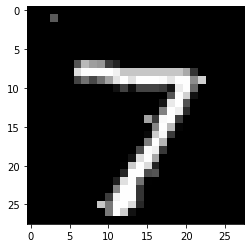

3


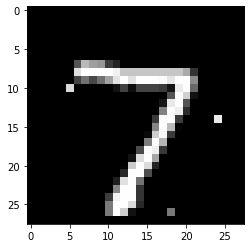

1


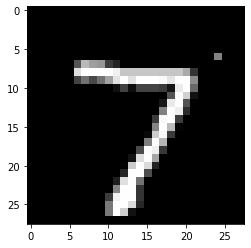

3


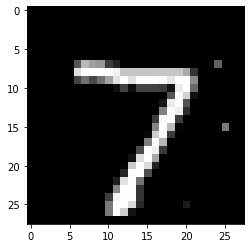

5


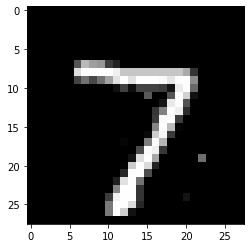

5


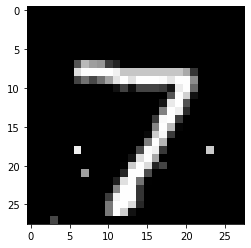

2


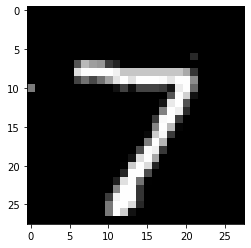

5


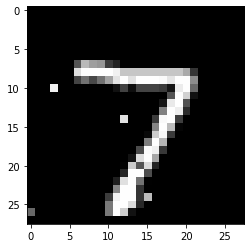

4


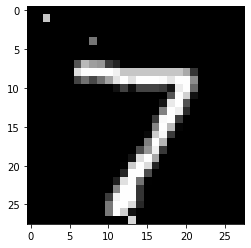

5


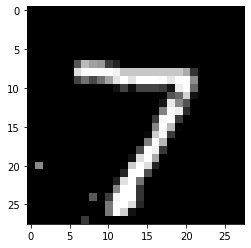

3


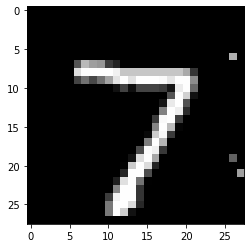

3


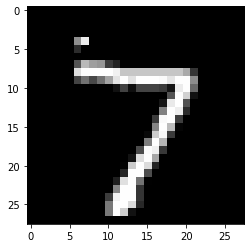

3


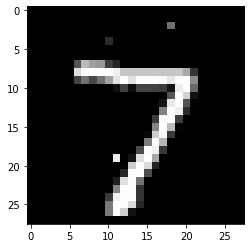

5


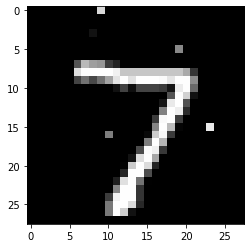

2


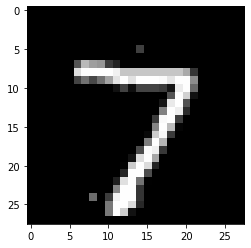

1


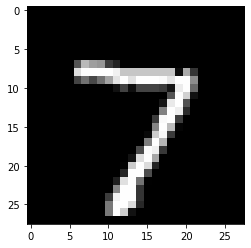

4


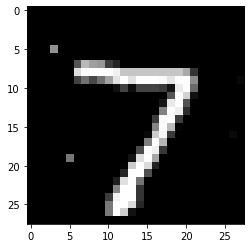

3


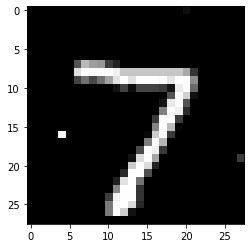

2


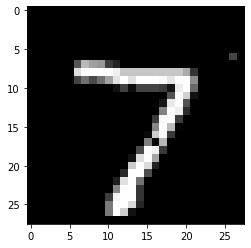

5


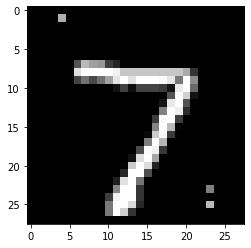

3


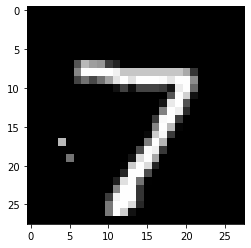

2


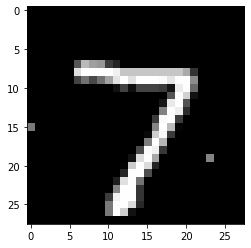

1


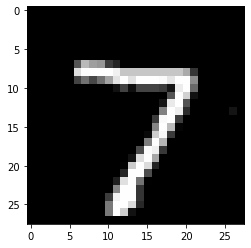

1


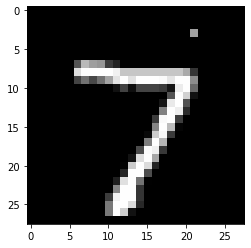

2


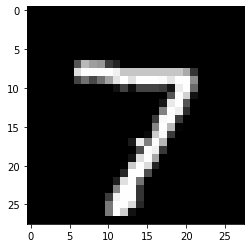

4


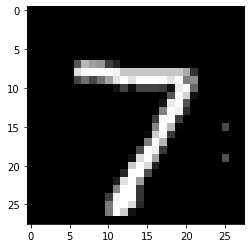

5


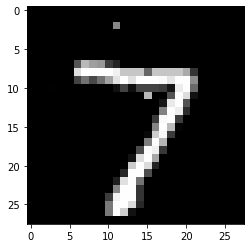

3


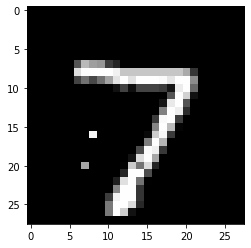

5


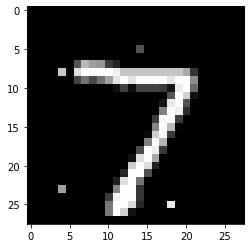

5


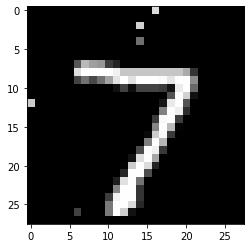

1


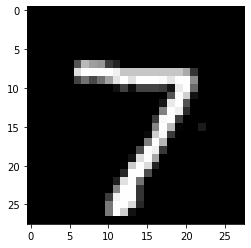

1


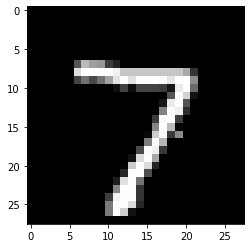

4


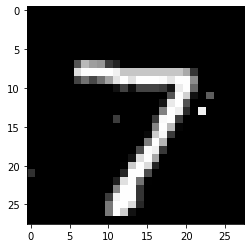

3


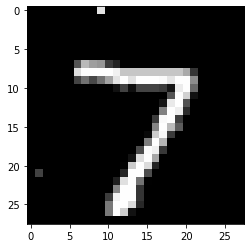

3


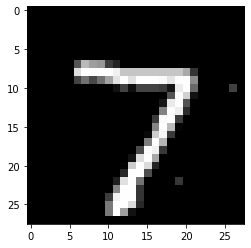

1


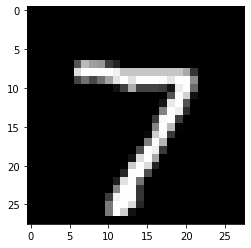

2


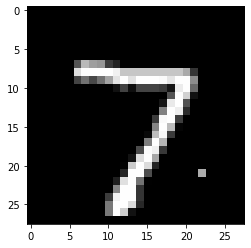

2


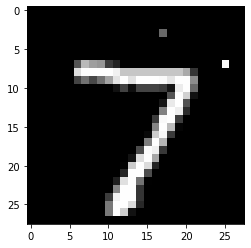

3


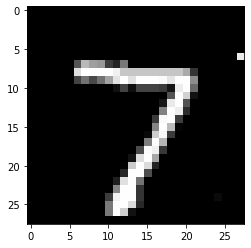

1


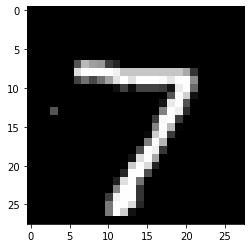

2


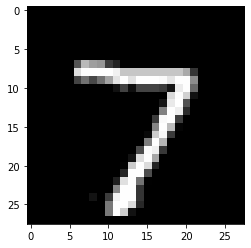

3


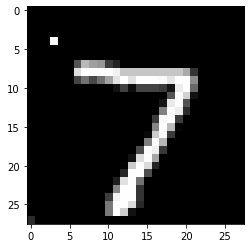

4


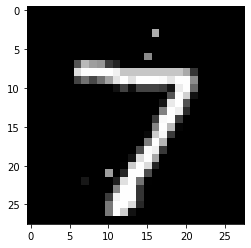

4


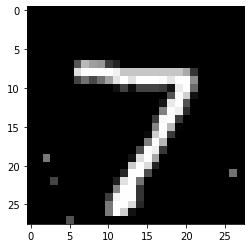

4


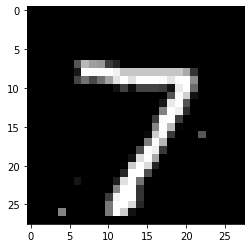

2


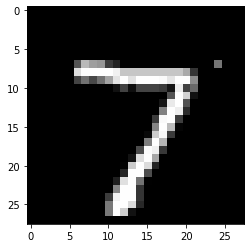

5


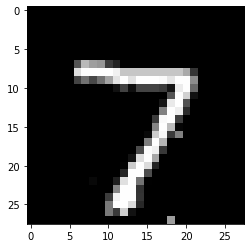

2


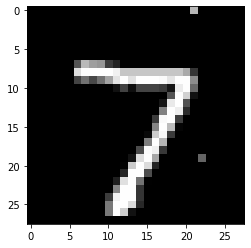

4


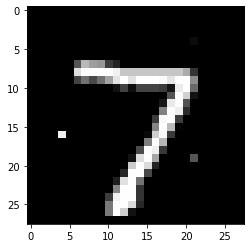

5


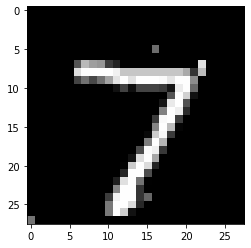

1


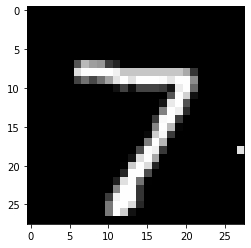

2


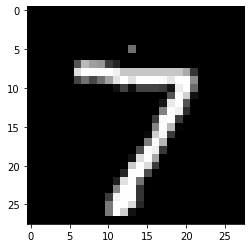

1


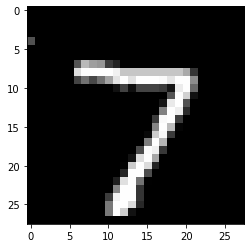

2


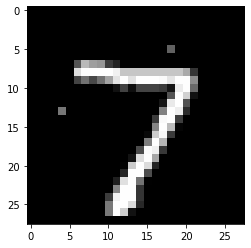

4


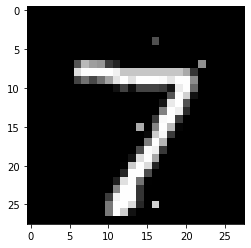

3


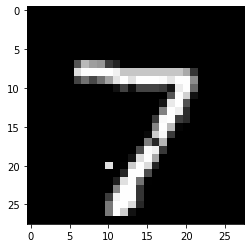

1


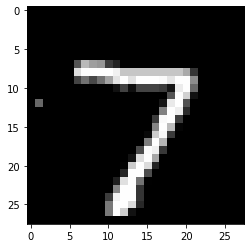

1


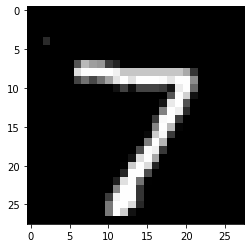

5


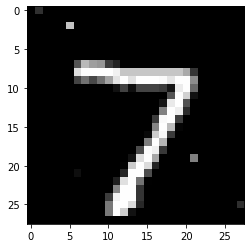

4


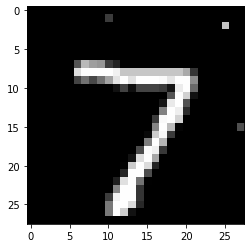

4


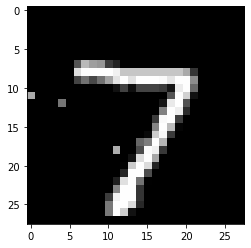

5


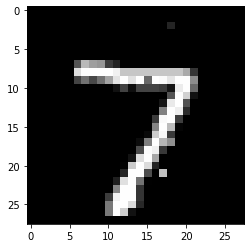

3


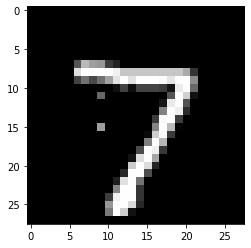

2


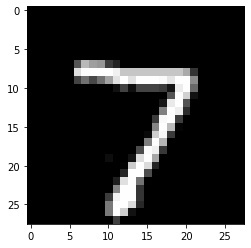

2


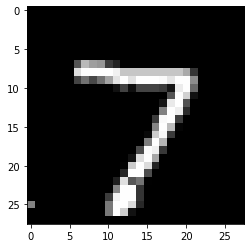

5


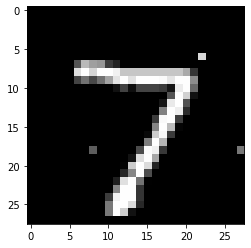

4


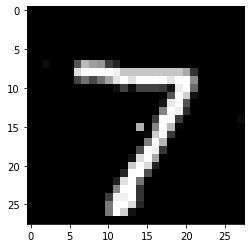

1


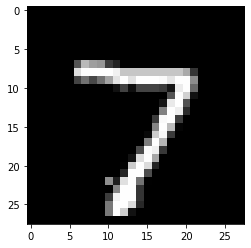

5


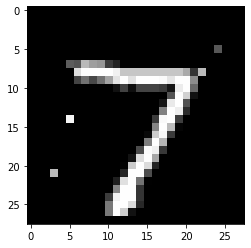

2


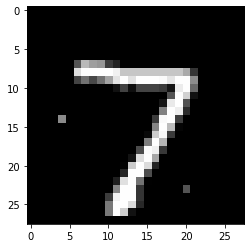

4


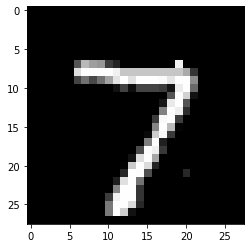

5


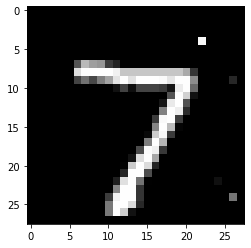

5


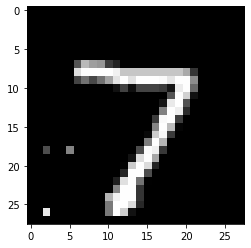

3


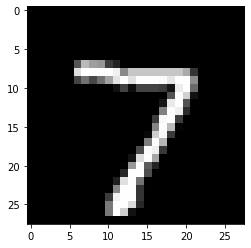

1


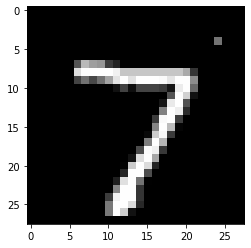

4


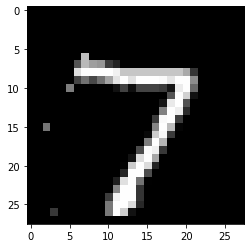

1


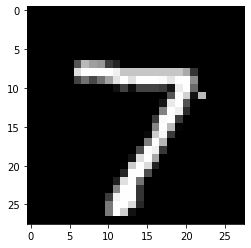

1


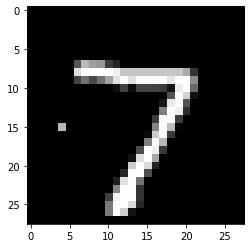

5


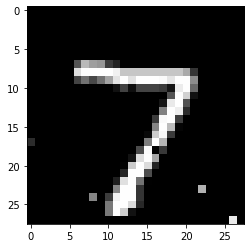

1


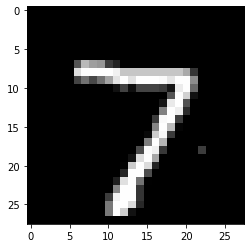

3


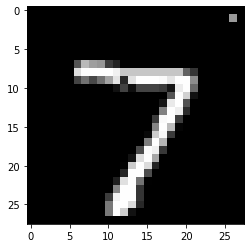

3


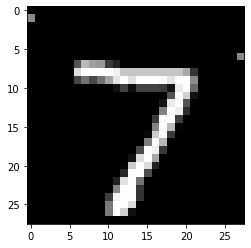

2


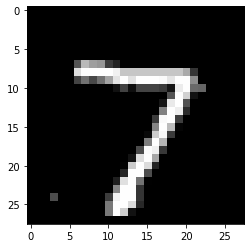

4


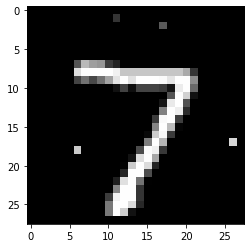

2


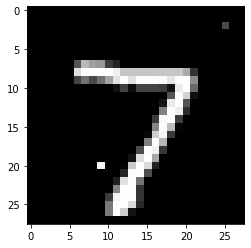

4


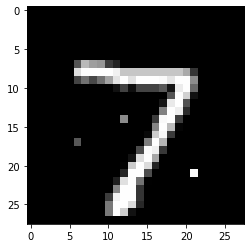

4


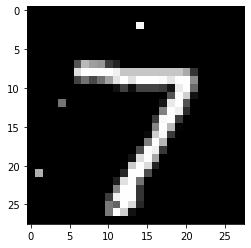

3


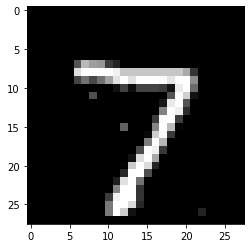

1


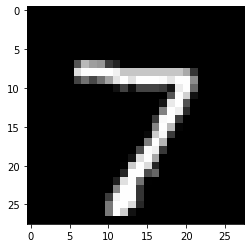

2


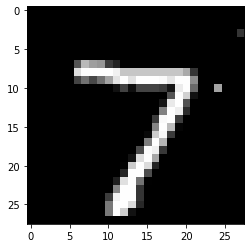

2


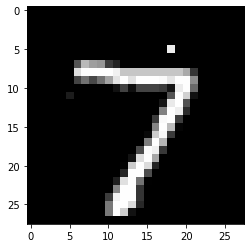

5


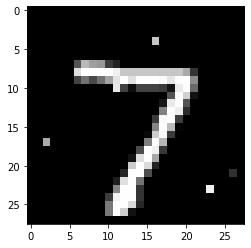

1


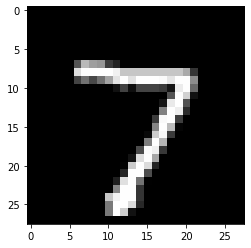

3


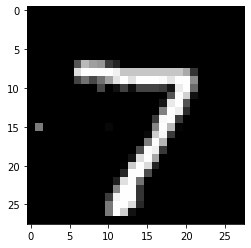

4


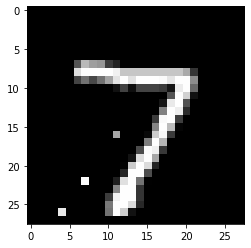

5


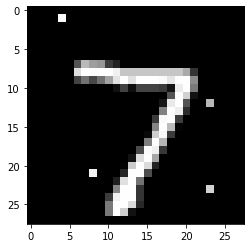

2


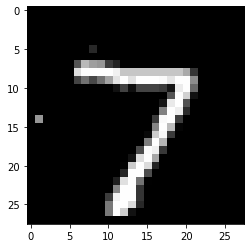

1


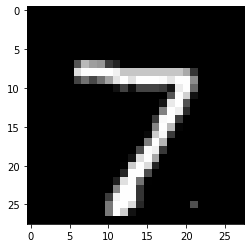

3


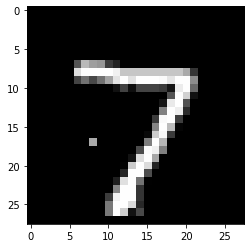

2


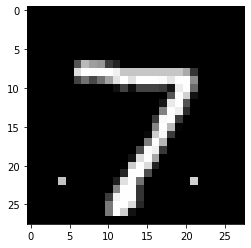

In [4]:
x_des = []
for r in range(100):
    x = []
    y = []
    L = random.randint(1,5)
    for i in range(L):
        x.append(random.randint(0,27))
        y.append(random.randint(0,27))
        #if x_test[0][x[i],y[i]] == 0:
        x_tmp[x[i],y[i]] = random.randint(0,254) 
    x_t = x_tmp/255-x_test[0]/255
    x_des.append(np.array(x_t.reshape(1,784)))
    print(L)
    plt.imshow(x_tmp,cmap='gray')
    plt.show()
    x_tmp = copy.deepcopy(x_test[0])

In [4]:
x_train = x_train.reshape(60000,784)    # 将图片摊平，变成向量

In [5]:
x_test = x_test.reshape(10000,784)     # 对测试集进行同样的处理

In [6]:
x_train = x_train / 255
x_test = x_test / 255 

In [7]:
model = load_model('mnist_model.h5')

In [8]:
def Func(x):
    x_F = x[:]+x_test[0]
    result=model.predict(x_F.reshape(1,784))
    return result[0][7]

In [9]:
def Dis(x):   # 扰动值
    res = 0
    for i in range(784):
        l = x[i]
        res += l**2
    return res

In [12]:
# 攻击模块
class Atk(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Atk, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        self.cond.acquire()
        print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            DB = Dis(BEST_X)    # 存储上一代的扰动程度
            Db[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i])
                
                D_ = DIS_U[i] - DB
                # 变异的种子表现更好
                if FITS[i] >= FITS_U[i] and D_ < 0.1:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if FITS_U[i] < Func(BEST_X) and D_ < 0.1:
                        BEST_X = U[i, :]
            GENERATION += 1
            
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Db ","最优值：", Func(Db),"扰动程度：",Dis(Db))
            best[:] = Db[:]
            if Func(best) > 0.6:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= 0.6:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")        
            if s == 1:
                best[:] = Db[:]
            
            if Func(BEST_X) <= F:
                print(" ")
                print(" ")
                print("Resume")
                if D <= 10.5:
                    D += 0.5 
                self.cond.notify()  # 唤醒一个挂起的线程
                self.cond.wait()
        self.cond.release()


# 恢复模块
class Re(threading.Thread):

    def __init__(self,cond,name):
        #threading.Thread.__init__(self)
        super(Re, self).__init__()
        self.cond = cond
        self.name = name

    def run(self):
        #time.sleep(1)
        self.cond.acquire()
        self.cond.wait()
        #print(self.name)
        global F
        global D
        global BEST_X
        global GENERATION
        #global best
        while GENERATION < MAX_GENERATION:
        #while Func(BEST_X) >= 0.35 or Dis(BEST_X) >= 6.5:
        #for t in range(5):
            #print(Func(BEST_X))
            FB = Func(BEST_X)    # 存储上一代的置信度
            Fb[:] = best[:]
            s = 1
            
            # 变异
            for i in range(N):
                r = np.random.randint(1, N, 2)
                V[i, :] = BEST_X + SIGMA * (X[r[0], :] - X[r[1], :])
                for j in range(784):
                    if V[i, j] > 1:
                        #print(V[i, j])
                        V[i, j] = 1-(V[i, j]-1)
                        #print(V[i, j])
                    elif V[i, j] <= 1:
                        if V[i, j] + x_test[0][j] > 1:
                            # V +t = 1-(V+t-1)
                            V[i, j] = 1-(V[i, j]+2*x_test[0][j]-1)
                            #print(V[i, j])
                        elif V[i, j] + x_test[0][j] < 0:
                            V[i, j] = -x_test[0][j]
            # print(V)
            # 交叉操作
            for i in range(N):
                jRand = np.floor(np.random.random() * L)
                for j in range(L):
                    # 至少有一个分量对U[i,j]作出了贡献
                    # CR调小 有利于往BEST_X的方向进化
                    if np.random.random() > CR or j == jRand:
                        U[i, j] = X[i, j]
                    else:
                        U[i, j] = V[i, j]
                    #if np.random.random() < CR or j == jRand:
                        #U[i, j] = V[i, j]
                    #else:
                        #U[i, j] = X[i, j]
            # 计算适应度值+选择操作
            for i in range(N):
                FITS[i] = Func(X[i])
                FITS_U[i] = Func(U[i])
                DIS[i] = Dis(X[i])
                DIS_U[i] = Dis(U[i]) 
                F_ = FITS_U[i] - FB
                
                # 变异的种子表现更好
                #if FITS[i] >= FITS_U[i] and DIS[i] >= DIS_U[i]:
                if DIS[i] >= DIS_U[i] and F_ < 0.01:
                    X[i, :] = U[i, :]
                    FITS[i] = FITS_U[i]
                    if DIS_U[i] < Dis(BEST_X) and F_ < 0.01:
                        BEST_X = U[i, :]
            GENERATION += 1
            #print(F_)
            print("最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X),"代数：",GENERATION)
            #print("Fb ","最优值：", Func(Fb),"扰动程度：",Dis(Fb))
            best[:] = Fb[:]
            if Func(best) > 0.6:
                s -= 1     # 触发（检测此步骤是否有执行）
                best[:] = BEST_X[:]
                print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            if s == 1:
                best[:] = Fb[:]
            
            if Func(BEST_X) <= 0.6:
                if Func(BEST_X) < Func(best) and Dis(BEST_X) < Dis(best):   # 保存最好的数值
                    s -= 1     # 触发（检测此步骤是否有执行）
                    #print("test-B","最优值：", Func(BEST_X),"扰动程度：",Dis(BEST_X))
                    #print("test-b","最优值：", Func(best),"扰动程度：",Dis(best))
                    best[:] = BEST_X[:]
                    print("best ","最优值：", Func(best),"扰动程度：",Dis(best))
            print(" ")         
            if s == 1:
                best[:] = Fb[:]
            
            if Dis(BEST_X) <= D:
                print(" ")
                print(" ")
                print("Attack")
                if F > 0.4:
                    F -= 0.05
                self.cond.notify()
                self.cond.wait()
        self.cond.release()
        

In [13]:
MAX_GENERATION = 5000  # 最大迭代次数
GENERATION = 0  # 当前代数
L = 784  # 种子的维度
N = 100  # 种群规模
SIGMA = 0.333  # 缩放因子
CR = 0.1  # 交叉概率
F = 0.9   #置信度参数
D = 7.0   #扰动参数
cond = threading.Condition()
atk = Atk(cond, "Attack")
re = Re(cond, "Resume")
best = 0
GENERATION = 0  # 当前代数
BEST_X = 0
FITS = np.zeros(N)
FITS_U = np.zeros(N)
DIS = np.zeros(N)
DIS_U = np.zeros(N)
V = np.zeros((N, L))
U = np.zeros((N, L))
Db = np.zeros(L)
Fb = np.zeros(L)
# 1、初始化
X = np.concatenate(x_des, axis=0)
# 找出随机生成的最好的种子
for i in range(N):
    FITS[i] = Func(X[i])
# 找出最好的种子 适应度值最小
BEST_X = X[np.argmin(FITS)]
best = X[np.argmin(FITS)]
re.start()
atk.start()

#re.join()
#atk.join()

Attack
最优值： 0.9944431 扰动程度： 2.448627450980392 代数： 1
best  最优值： 0.9944431 扰动程度： 2.448627450980392
 
最优值： 0.9944431 扰动程度： 2.448627450980392 代数： 2
best  最优值： 0.9944431 扰动程度： 2.448627450980392
 
最优值： 0.99441624 扰动程度： 2.453651336989251 代数： 3
best  最优值： 0.99441624 扰动程度： 2.453651336989251
 
最优值： 0.99441624 扰动程度： 2.453651336989251 代数： 4
best  最优值： 0.99441624 扰动程度： 2.453651336989251
 
最优值： 0.99433386 扰动程度： 2.632543243910867 代数： 5
best  最优值： 0.99433386 扰动程度： 2.632543243910867
 
最优值： 0.9931022 扰动程度： 2.4828718334224 代数： 6
best  最优值： 0.9931022 扰动程度： 2.4828718334224
 
最优值： 0.99300027 扰动程度： 2.4943384637338184 代数： 7
best  最优值： 0.99300027 扰动程度： 2.4943384637338184
 
最优值： 0.992969 扰动程度： 2.495042113006628 代数： 8
best  最优值： 0.992969 扰动程度： 2.495042113006628
 
最优值： 0.9929299 扰动程度： 2.5859910480811745 代数： 9
best  最优值： 0.9929299 扰动程度： 2.5859910480811745
 
最优值： 0.9929468 扰动程度： 2.5505881182648142 代数： 10
best  最优值： 0.9929468 扰动程度： 2.5505881182648142
 
最优值： 0.9929468 扰动程度： 2.5505881182648142 代数： 11
best  最优值： 0.9929

最优值： 0.96869254 扰动程度： 5.0873603710561035 代数： 89
best  最优值： 0.96869254 扰动程度： 5.0873603710561035
 
最优值： 0.96790206 扰动程度： 4.929889034115055 代数： 90
best  最优值： 0.96790206 扰动程度： 4.929889034115055
 
最优值： 0.96857834 扰动程度： 4.9235672622284286 代数： 91
best  最优值： 0.96857834 扰动程度： 4.9235672622284286
 
最优值： 0.9678486 扰动程度： 4.931902882771996 代数： 92
best  最优值： 0.9678486 扰动程度： 4.931902882771996
 
最优值： 0.96773416 扰动程度： 4.95146558197315 代数： 93
best  最优值： 0.96773416 扰动程度： 4.95146558197315
 
最优值： 0.9681861 扰动程度： 4.90650276197205 代数： 94
best  最优值： 0.9681861 扰动程度： 4.90650276197205
 
最优值： 0.9675713 扰动程度： 4.964683334741421 代数： 95
best  最优值： 0.9675713 扰动程度： 4.964683334741421
 
最优值： 0.9674163 扰动程度： 4.968184244427193 代数： 96
best  最优值： 0.9674163 扰动程度： 4.968184244427193
 
最优值： 0.9672415 扰动程度： 4.998614454616022 代数： 97
best  最优值： 0.9672415 扰动程度： 4.998614454616022
 
最优值： 0.9674078 扰动程度： 4.974217045446023 代数： 98
best  最优值： 0.9674078 扰动程度： 4.974217045446023
 
最优值： 0.96727806 扰动程度： 4.976654102570403 代数： 99
best  最优值： 0.96

最优值： 0.9057248 扰动程度： 8.17330870003657 代数： 176
best  最优值： 0.9057248 扰动程度： 8.17330870003657
 
最优值： 0.91564345 扰动程度： 7.537488740800136 代数： 177
best  最优值： 0.91564345 扰动程度： 7.537488740800136
 
最优值： 0.9226864 扰动程度： 7.411765066071442 代数： 178
best  最优值： 0.9226864 扰动程度： 7.411765066071442
 
 
 
Attack
最优值： 0.92325866 扰动程度： 7.402532062694464 代数： 179
best  最优值： 0.92325866 扰动程度： 7.402532062694464
 
最优值： 0.92239064 扰动程度： 7.443181546465108 代数： 180
best  最优值： 0.92239064 扰动程度： 7.443181546465108
 
最优值： 0.9155077 扰动程度： 7.53759123838727 代数： 181
best  最优值： 0.9155077 扰动程度： 7.53759123838727
 
最优值： 0.9129765 扰动程度： 7.688960500115182 代数： 182
best  最优值： 0.9129765 扰动程度： 7.688960500115182
 
最优值： 0.908353 扰动程度： 7.729752988245672 代数： 183
best  最优值： 0.908353 扰动程度： 7.729752988245672
 
最优值： 0.90697646 扰动程度： 7.829260923697408 代数： 184
best  最优值： 0.90697646 扰动程度： 7.829260923697408
 
最优值： 0.9075644 扰动程度： 7.7780205992520335 代数： 185
best  最优值： 0.9075644 扰动程度： 7.7780205992520335
 
最优值： 0.90733933 扰动程度： 7.820416741313659 代数： 1

最优值： 0.8656714 扰动程度： 9.274758506201179 代数： 263
best  最优值： 0.8656714 扰动程度： 9.274758506201179
 
最优值： 0.8657023 扰动程度： 9.282868395122513 代数： 264
best  最优值： 0.8657023 扰动程度： 9.282868395122513
 
最优值： 0.86542714 扰动程度： 9.312286211461487 代数： 265
best  最优值： 0.86542714 扰动程度： 9.312286211461487
 
最优值： 0.8628326 扰动程度： 9.402698496534743 代数： 266
best  最优值： 0.8628326 扰动程度： 9.402698496534743
 
最优值： 0.8627937 扰动程度： 9.40254632842993 代数： 267
best  最优值： 0.8627937 扰动程度： 9.40254632842993
 
最优值： 0.86114126 扰动程度： 9.484065713854672 代数： 268
best  最优值： 0.86114126 扰动程度： 9.484065713854672
 
最优值： 0.85711086 扰动程度： 9.551437128635566 代数： 269
best  最优值： 0.85711086 扰动程度： 9.551437128635566
 
最优值： 0.8530989 扰动程度： 9.728260705251955 代数： 270
best  最优值： 0.8530989 扰动程度： 9.728260705251955
 
最优值： 0.85011756 扰动程度： 9.82061858180846 代数： 271
best  最优值： 0.85011756 扰动程度： 9.82061858180846
 
最优值： 0.8462056 扰动程度： 9.918950448266362 代数： 272
best  最优值： 0.8462056 扰动程度： 9.918950448266362
 
最优值： 0.84815824 扰动程度： 9.849253657530856 代数： 273
best  最优

最优值： 0.85204726 扰动程度： 9.4247163564652 代数： 350
best  最优值： 0.85204726 扰动程度： 9.4247163564652
 
最优值： 0.8490443 扰动程度： 9.522030460741275 代数： 351
best  最优值： 0.8490443 扰动程度： 9.522030460741275
 
最优值： 0.84738123 扰动程度： 9.57655229088519 代数： 352
best  最优值： 0.84738123 扰动程度： 9.57655229088519
 
最优值： 0.84705955 扰动程度： 9.597011168992648 代数： 353
best  最优值： 0.84705955 扰动程度： 9.597011168992648
 
最优值： 0.8452337 扰动程度： 9.658171487790328 代数： 354
best  最优值： 0.8452337 扰动程度： 9.658171487790328
 
最优值： 0.8447897 扰动程度： 9.674205257091751 代数： 355
best  最优值： 0.8447897 扰动程度： 9.674205257091751
 
最优值： 0.8400766 扰动程度： 9.844018857305663 代数： 356
best  最优值： 0.8400766 扰动程度： 9.844018857305663
 
最优值： 0.84050804 扰动程度： 9.85982424791573 代数： 357
best  最优值： 0.84050804 扰动程度： 9.85982424791573
 
最优值： 0.8400562 扰动程度： 9.866898467185356 代数： 358
best  最优值： 0.8400562 扰动程度： 9.866898467185356
 
最优值： 0.8408551 扰动程度： 9.927988324876267 代数： 359
best  最优值： 0.8408551 扰动程度： 9.927988324876267
 
最优值： 0.8401898 扰动程度： 9.93177012971247 代数： 360
best  最优值： 0.8

最优值： 0.8677824 扰动程度： 8.960767646892524 代数： 436
best  最优值： 0.8677824 扰动程度： 8.960767646892524
 
最优值： 0.86249363 扰动程度： 9.04025218717688 代数： 437
best  最优值： 0.86249363 扰动程度： 9.04025218717688
 
最优值： 0.8614674 扰动程度： 9.086195318644466 代数： 438
best  最优值： 0.8614674 扰动程度： 9.086195318644466
 
最优值： 0.8615713 扰动程度： 9.067393101448756 代数： 439
best  最优值： 0.8615713 扰动程度： 9.067393101448756
 
最优值： 0.8593159 扰动程度： 9.14700344543504 代数： 440
best  最优值： 0.8593159 扰动程度： 9.14700344543504
 
最优值： 0.8572965 扰动程度： 9.195593943733202 代数： 441
best  最优值： 0.8572965 扰动程度： 9.195593943733202
 
最优值： 0.8520413 扰动程度： 9.29116099770808 代数： 442
best  最优值： 0.8520413 扰动程度： 9.29116099770808
 
最优值： 0.8496918 扰动程度： 9.382712624716344 代数： 443
best  最优值： 0.8496918 扰动程度： 9.382712624716344
 
最优值： 0.8497997 扰动程度： 9.418221394394056 代数： 444
best  最优值： 0.8497997 扰动程度： 9.418221394394056
 
最优值： 0.8493752 扰动程度： 9.49820741075489 代数： 445
best  最优值： 0.8493752 扰动程度： 9.49820741075489
 
最优值： 0.8431591 扰动程度： 9.568996443663274 代数： 446
best  最优值： 0.843159

最优值： 0.70190823 扰动程度： 13.332491731012103 代数： 522
best  最优值： 0.70190823 扰动程度： 13.332491731012103
 
最优值： 0.699519 扰动程度： 13.416165846243686 代数： 523
best  最优值： 0.699519 扰动程度： 13.416165846243686
 
 
 
Resume
最优值： 0.7090002 扰动程度： 13.206868695480843 代数： 524
best  最优值： 0.7090002 扰动程度： 13.206868695480843
 
最优值： 0.7187561 扰动程度： 12.941435525078365 代数： 525
best  最优值： 0.7187561 扰动程度： 12.941435525078365
 
最优值： 0.7241294 扰动程度： 12.788325704860407 代数： 526
best  最优值： 0.7241294 扰动程度： 12.788325704860407
 
最优值： 0.7333829 扰动程度： 12.587974082212318 代数： 527
best  最优值： 0.7333829 扰动程度： 12.587974082212318
 
最优值： 0.7402261 扰动程度： 12.38110216292436 代数： 528
best  最优值： 0.7402261 扰动程度： 12.38110216292436
 
最优值： 0.7448845 扰动程度： 12.340449976164187 代数： 529
best  最优值： 0.7448845 扰动程度： 12.340449976164187
 
最优值： 0.7493573 扰动程度： 12.140982167238201 代数： 530
best  最优值： 0.7493573 扰动程度： 12.140982167238201
 
最优值： 0.7524457 扰动程度： 12.036809763769433 代数： 531
best  最优值： 0.7524457 扰动程度： 12.036809763769433
 
最优值： 0.75997585 扰动程度： 11.929961

最优值： 0.7336952 扰动程度： 12.239810937982174 代数： 608
best  最优值： 0.7336952 扰动程度： 12.239810937982174
 
最优值： 0.73200345 扰动程度： 12.332927448854539 代数： 609
best  最优值： 0.73200345 扰动程度： 12.332927448854539
 
最优值： 0.72830164 扰动程度： 12.35817122856517 代数： 610
best  最优值： 0.72830164 扰动程度： 12.35817122856517
 
最优值： 0.72569597 扰动程度： 12.354009949265564 代数： 611
best  最优值： 0.72569597 扰动程度： 12.354009949265564
 
最优值： 0.72536063 扰动程度： 12.448849009056977 代数： 612
best  最优值： 0.72536063 扰动程度： 12.448849009056977
 
最优值： 0.7219737 扰动程度： 12.492913133323526 代数： 613
best  最优值： 0.7219737 扰动程度： 12.492913133323526
 
最优值： 0.72112596 扰动程度： 12.531110435335204 代数： 614
best  最优值： 0.72112596 扰动程度： 12.531110435335204
 
最优值： 0.7154353 扰动程度： 12.610099312946561 代数： 615
best  最优值： 0.7154353 扰动程度： 12.610099312946561
 
最优值： 0.71156514 扰动程度： 12.715680288432047 代数： 616
best  最优值： 0.71156514 扰动程度： 12.715680288432047
 
最优值： 0.7108136 扰动程度： 12.73924391242746 代数： 617
best  最优值： 0.7108136 扰动程度： 12.73924391242746
 
最优值： 0.71009266 扰动程度： 12.7678355

最优值： 0.8064727 扰动程度： 10.264789160239557 代数： 693
best  最优值： 0.8064727 扰动程度： 10.264789160239557
 
最优值： 0.80315804 扰动程度： 10.326020950615353 代数： 694
best  最优值： 0.80315804 扰动程度： 10.326020950615353
 
最优值： 0.80157024 扰动程度： 10.380997362128989 代数： 695
best  最优值： 0.80157024 扰动程度： 10.380997362128989
 
最优值： 0.8015194 扰动程度： 10.384118941986102 代数： 696
best  最优值： 0.8015194 扰动程度： 10.384118941986102
 
最优值： 0.79680663 扰动程度： 10.494400151288929 代数： 697
best  最优值： 0.79680663 扰动程度： 10.494400151288929
 
最优值： 0.79183984 扰动程度： 10.601616688676454 代数： 698
best  最优值： 0.79183984 扰动程度： 10.601616688676454
 
最优值： 0.7891127 扰动程度： 10.667713556911615 代数： 699
best  最优值： 0.7891127 扰动程度： 10.667713556911615
 
最优值： 0.7850744 扰动程度： 10.77447154605648 代数： 700
best  最优值： 0.7850744 扰动程度： 10.77447154605648
 
最优值： 0.78117067 扰动程度： 10.86151441490191 代数： 701
best  最优值： 0.78117067 扰动程度： 10.86151441490191
 
最优值： 0.7788687 扰动程度： 10.91301173111533 代数： 702
best  最优值： 0.7788687 扰动程度： 10.91301173111533
 
最优值： 0.7762024 扰动程度： 10.980314342103

最优值： 0.60596555 扰动程度： 15.095664697579416 代数： 779
best  最优值： 0.60596555 扰动程度： 15.095664697579416
 
最优值： 0.606014 扰动程度： 15.124311911029498 代数： 780
best  最优值： 0.606014 扰动程度： 15.124311911029498
 
最优值： 0.60268086 扰动程度： 15.209477056635867 代数： 781
best  最优值： 0.60268086 扰动程度： 15.209477056635867
 
最优值： 0.59999824 扰动程度： 15.302458803112165 代数： 782
best  最优值： 0.59999824 扰动程度： 15.302458803112165
 
 
 
Resume
最优值： 0.6093983 扰动程度： 15.038198668870884 代数： 783
 
最优值： 0.61923707 扰动程度： 14.83485702423802 代数： 784
 
最优值： 0.62867653 扰动程度： 14.541538805585889 代数： 785
 
最优值： 0.6305779 扰动程度： 14.432426133361739 代数： 786
 
最优值： 0.63562804 扰动程度： 14.394536235275973 代数： 787
 
最优值： 0.6434563 扰动程度： 14.11241023707733 代数： 788
 
最优值： 0.6410982 扰动程度： 14.140563044641153 代数： 789
 
最优值： 0.6509297 扰动程度： 13.947795915452057 代数： 790
 
最优值： 0.6509297 扰动程度： 13.947795915452057 代数： 791
 
最优值： 0.6565293 扰动程度： 13.858458359443238 代数： 792
 
最优值： 0.65782225 扰动程度： 13.832360927459867 代数： 793
 
最优值： 0.6665857 扰动程度： 13.588651723541545 代数： 794
 

最优值： 0.5614906 扰动程度： 15.835352755805227 代数： 938
 
最优值： 0.5598727 扰动程度： 15.849913682404893 代数： 939
 
最优值： 0.5580037 扰动程度： 15.894013102916183 代数： 940
 
最优值： 0.5571307 扰动程度： 15.929111541533462 代数： 941
 
最优值： 0.55579865 扰动程度： 16.00414447169695 代数： 942
 
最优值： 0.55251795 扰动程度： 16.0623650960588 代数： 943
 
最优值： 0.5514758 扰动程度： 16.066629059550053 代数： 944
 
最优值： 0.55069685 扰动程度： 16.125196122270072 代数： 945
 
最优值： 0.5498667 扰动程度： 16.177699812348376 代数： 946
 
 
 
Resume
最优值： 0.558177 扰动程度： 15.851640526707506 代数： 947
 
最优值： 0.56583315 扰动程度： 15.701078495702468 代数： 948
 
最优值： 0.5742647 扰动程度： 15.555773445016472 代数： 949
 
最优值： 0.5798481 扰动程度： 15.531454513274182 代数： 950
 
最优值： 0.57996583 扰动程度： 15.381746051410726 代数： 951
 
最优值： 0.5822428 扰动程度： 15.327123580860029 代数： 952
 
最优值： 0.58555627 扰动程度： 15.332827314772494 代数： 953
 
最优值： 0.58367616 扰动程度： 15.269676114836827 代数： 954
 
最优值： 0.58429295 扰动程度： 15.172009881755555 代数： 955
 
最优值： 0.58577424 扰动程度： 15.137970159979735 代数： 956
 
最优值： 0.59161925 扰动程度： 15.032761017

最优值： 0.60655826 扰动程度： 14.208236760055415 代数： 1099
 
最优值： 0.6048376 扰动程度： 14.252869738888418 代数： 1100
 
最优值： 0.6017962 扰动程度： 14.323011970717163 代数： 1101
 
最优值： 0.59780276 扰动程度： 14.3577475769162 代数： 1102
 
最优值： 0.59731174 扰动程度： 14.364541052633623 代数： 1103
 
最优值： 0.5969772 扰动程度： 14.369258315935372 代数： 1104
 
最优值： 0.5964434 扰动程度： 14.419347953656882 代数： 1105
 
最优值： 0.59402364 扰动程度： 14.496023778711422 代数： 1106
 
最优值： 0.5932065 扰动程度： 14.553076059707832 代数： 1107
 
最优值： 0.5925702 扰动程度： 14.639298819974822 代数： 1108
 
最优值： 0.5900779 扰动程度： 14.62030702403722 代数： 1109
best  最优值： 0.5900779 扰动程度： 14.62030702403722
 
最优值： 0.58974 扰动程度： 14.623474740558413 代数： 1110
 
最优值： 0.5891079 扰动程度： 14.693944912151695 代数： 1111
 
最优值： 0.5872814 扰动程度： 14.707595451183886 代数： 1112
 
最优值： 0.58339196 扰动程度： 14.694785667894063 代数： 1113
 
最优值： 0.57886475 扰动程度： 14.73595351614257 代数： 1114
 
最优值： 0.57750416 扰动程度： 14.832036576960068 代数： 1115
 
最优值： 0.57097554 扰动程度： 14.912736493186527 代数： 1116
 
最优值： 0.57087463 扰动程度： 14.9239881606

最优值： 0.7298175 扰动程度： 11.646658783708496 代数： 1257
 
最优值： 0.72761 扰动程度： 11.745950930054732 代数： 1258
 
最优值： 0.7217582 扰动程度： 11.840534419535995 代数： 1259
 
最优值： 0.71473783 扰动程度： 11.957616814625833 代数： 1260
 
最优值： 0.7108935 扰动程度： 12.029968182542516 代数： 1261
 
最优值： 0.7093634 扰动程度： 12.084956122881852 代数： 1262
 
最优值： 0.71059793 扰动程度： 12.060010217111277 代数： 1263
 
最优值： 0.70696425 扰动程度： 12.021000300792693 代数： 1264
 
最优值： 0.7037461 扰动程度： 12.0894922377266 代数： 1265
 
最优值： 0.7024362 扰动程度： 12.106303187211195 代数： 1266
 
最优值： 0.69538206 扰动程度： 12.260070262851219 代数： 1267
 
最优值： 0.6985558 扰动程度： 12.219350195848184 代数： 1268
 
最优值： 0.69962466 扰动程度： 12.251753667726463 代数： 1269
 
最优值： 0.6941235 扰动程度： 12.255201539795493 代数： 1270
 
最优值： 0.6927795 扰动程度： 12.290619106211578 代数： 1271
 
最优值： 0.6915098 扰动程度： 12.330380381589514 代数： 1272
 
最优值： 0.688285 扰动程度： 12.337271341300596 代数： 1273
 
最优值： 0.68632805 扰动程度： 12.348459384762293 代数： 1274
 
最优值： 0.6849581 扰动程度： 12.405509012916816 代数： 1275
 
最优值： 0.68342316 扰动程度： 12.48822

最优值： 0.51289415 扰动程度： 15.797843563330755 代数： 1416
 
最优值： 0.51636046 扰动程度： 15.694535447452242 代数： 1417
 
最优值： 0.5169961 扰动程度： 15.690751514879913 代数： 1418
 
最优值： 0.5244469 扰动程度： 15.569197947585502 代数： 1419
 
最优值： 0.5239922 扰动程度： 15.561746298243333 代数： 1420
 
最优值： 0.5298187 扰动程度： 15.497697788985478 代数： 1421
 
最优值： 0.5394743 扰动程度： 15.229993928483283 代数： 1422
 
最优值： 0.5454212 扰动程度： 15.12936562096426 代数： 1423
 
最优值： 0.54525405 扰动程度： 15.131494284483805 代数： 1424
 
最优值： 0.5473044 扰动程度： 15.071763388263594 代数： 1425
 
最优值： 0.55077094 扰动程度： 15.036879574796309 代数： 1426
 
最优值： 0.5509847 扰动程度： 15.033977259363423 代数： 1427
 
最优值： 0.5532582 扰动程度： 14.867449872131322 代数： 1428
 
最优值： 0.5536124 扰动程度： 14.850321811334252 代数： 1429
 
最优值： 0.5584793 扰动程度： 14.792531400881154 代数： 1430
 
最优值： 0.5613302 扰动程度： 14.725928718241565 代数： 1431
 
最优值： 0.56895196 扰动程度： 14.644373210760236 代数： 1432
 
最优值： 0.56992346 扰动程度： 14.592716480316717 代数： 1433
 
最优值： 0.5705537 扰动程度： 14.567496777158144 代数： 1434
 
最优值： 0.57072324 扰动程度： 14.5

最优值： 0.6194734 扰动程度： 13.345346786892597 代数： 1576
 
最优值： 0.6185553 扰动程度： 13.38173186712544 代数： 1577
 
最优值： 0.6146495 扰动程度： 13.482858565167104 代数： 1578
 
最优值： 0.61209965 扰动程度： 13.532717872545154 代数： 1579
 
最优值： 0.60841435 扰动程度： 13.579115783948415 代数： 1580
 
最优值： 0.60856974 扰动程度： 13.577620395820146 代数： 1581
 
最优值： 0.604901 扰动程度： 13.651021307963973 代数： 1582
 
最优值： 0.6013757 扰动程度： 13.721098716625418 代数： 1583
 
最优值： 0.601264 扰动程度： 13.721243402170138 代数： 1584
 
最优值： 0.60275364 扰动程度： 13.674803114325876 代数： 1585
 
最优值： 0.5991015 扰动程度： 13.761246085184398 代数： 1586
 
最优值： 0.5932276 扰动程度： 13.906847188546873 代数： 1587
 
最优值： 0.59177727 扰动程度： 13.974987339284509 代数： 1588
 
最优值： 0.5880766 扰动程度： 14.056473941211129 代数： 1589
 
最优值： 0.58423126 扰动程度： 14.116376921510595 代数： 1590
 
最优值： 0.58229494 扰动程度： 14.214877926404577 代数： 1591
 
最优值： 0.5766536 扰动程度： 14.292984201681053 代数： 1592
best  最优值： 0.5766536 扰动程度： 14.292984201681053
 
最优值： 0.5714019 扰动程度： 14.411184620494522 代数： 1593
 
最优值： 0.5734807 扰动程度： 14.45175502

最优值： 0.52309483 扰动程度： 15.563548958102295 代数： 1735
 
最优值： 0.52991587 扰动程度： 15.476685021176339 代数： 1736
 
最优值： 0.5314129 扰动程度： 15.471925865876331 代数： 1737
 
最优值： 0.52425146 扰动程度： 15.421014805732048 代数： 1738
 
最优值： 0.52941966 扰动程度： 15.391618638838567 代数： 1739
 
最优值： 0.53269553 扰动程度： 15.32394078299243 代数： 1740
 
最优值： 0.53562146 扰动程度： 15.264803053838648 代数： 1741
 
最优值： 0.535934 扰动程度： 15.264112360333291 代数： 1742
 
最优值： 0.5392486 扰动程度： 15.167073957543632 代数： 1743
 
最优值： 0.5435548 扰动程度： 15.102037059128692 代数： 1744
 
最优值： 0.54421145 扰动程度： 15.08545188445892 代数： 1745
 
最优值： 0.5500766 扰动程度： 14.905258907943862 代数： 1746
 
最优值： 0.558494 扰动程度： 14.777220044268475 代数： 1747
 
最优值： 0.5630609 扰动程度： 14.667872674329368 代数： 1748
 
最优值： 0.5655173 扰动程度： 14.632149971086106 代数： 1749
 
最优值： 0.56635624 扰动程度： 14.608689345364247 代数： 1750
 
最优值： 0.56685936 扰动程度： 14.555721344329248 代数： 1751
 
最优值： 0.564987 扰动程度： 14.598406290077957 代数： 1752
 
最优值： 0.5730923 扰动程度： 14.51642012443428 代数： 1753
 
最优值： 0.57051134 扰动程度： 14.479

最优值： 0.6349796 扰动程度： 13.056056242443153 代数： 1895
 
最优值： 0.6337575 扰动程度： 13.116993576372522 代数： 1896
 
最优值： 0.63281727 扰动程度： 13.145599757082465 代数： 1897
 
最优值： 0.6314176 扰动程度： 13.162645898421564 代数： 1898
 
最优值： 0.6283437 扰动程度： 13.183567973801837 代数： 1899
 
最优值： 0.6273202 扰动程度： 13.208354944735765 代数： 1900
 
最优值： 0.62441045 扰动程度： 13.22860788534831 代数： 1901
 
最优值： 0.6221127 扰动程度： 13.327690338032832 代数： 1902
 
最优值： 0.62121624 扰动程度： 13.413595304607941 代数： 1903
 
最优值： 0.6159503 扰动程度： 13.4955882346584 代数： 1904
 
最优值： 0.61288726 扰动程度： 13.512842142593763 代数： 1905
 
最优值： 0.611249 扰动程度： 13.609518660694217 代数： 1906
 
最优值： 0.611249 扰动程度： 13.609518660694217 代数： 1907
 
最优值： 0.6096235 扰动程度： 13.595711660690517 代数： 1908
 
最优值： 0.60614735 扰动程度： 13.682761509660779 代数： 1909
 
最优值： 0.6055765 扰动程度： 13.689006627260486 代数： 1910
 
最优值： 0.60458064 扰动程度： 13.746942632449946 代数： 1911
 
最优值： 0.60016924 扰动程度： 13.84690182246195 代数： 1912
 
最优值： 0.5946465 扰动程度： 13.914176377378896 代数： 1913
 
最优值： 0.59517854 扰动程度： 13.89235

最优值： 0.5317345 扰动程度： 14.952808334802969 代数： 2055
 
最优值： 0.53585345 扰动程度： 14.959308909163584 代数： 2056
 
最优值： 0.54275334 扰动程度： 14.72528329854635 代数： 2057
 
最优值： 0.545518 扰动程度： 14.678337674953012 代数： 2058
 
最优值： 0.5489097 扰动程度： 14.57985004638726 代数： 2059
 
最优值： 0.55139816 扰动程度： 14.529209271083143 代数： 2060
 
最优值： 0.5577142 扰动程度： 14.450406497501355 代数： 2061
 
最优值： 0.5559349 扰动程度： 14.41143953089324 代数： 2062
 
最优值： 0.5573223 扰动程度： 14.388549897429606 代数： 2063
 
最优值： 0.56288606 扰动程度： 14.328400433104791 代数： 2064
 
最优值： 0.5629557 扰动程度： 14.324324492335014 代数： 2065
 
最优值： 0.5682009 扰动程度： 14.250222558924001 代数： 2066
best  最优值： 0.5682009 扰动程度： 14.250222558924001
 
最优值： 0.569016 扰动程度： 14.235310073380797 代数： 2067
 
最优值： 0.57753384 扰动程度： 14.121250616855022 代数： 2068
 
最优值： 0.5748993 扰动程度： 14.139785009844212 代数： 2069
 
最优值： 0.58403736 扰动程度： 13.989580135304168 代数： 2070
 
最优值： 0.5801196 扰动程度： 13.947977930707705 代数： 2071
 
最优值： 0.5797689 扰动程度： 13.954971634803714 代数： 2072
 
最优值： 0.586001 扰动程度： 13.899826757928

最优值： 0.64657706 扰动程度： 12.692014127632525 代数： 2215
 
最优值： 0.6457221 扰动程度： 12.769616152009094 代数： 2216
 
最优值： 0.64262486 扰动程度： 12.702549150371919 代数： 2217
 
最优值： 0.64319634 扰动程度： 12.790512763876704 代数： 2218
 
最优值： 0.6398708 扰动程度： 12.833391685940748 代数： 2219
 
最优值： 0.6360015 扰动程度： 12.91432396292495 代数： 2220
 
最优值： 0.63228065 扰动程度： 12.984126765050974 代数： 2221
 
最优值： 0.6242021 扰动程度： 13.064711044706396 代数： 2222
 
最优值： 0.6165852 扰动程度： 13.136943036543439 代数： 2223
 
最优值： 0.6162267 扰动程度： 13.141152941082138 代数： 2224
 
最优值： 0.615742 扰动程度： 13.151515671797645 代数： 2225
 
最优值： 0.614809 扰动程度： 13.247283021950055 代数： 2226
 
最优值： 0.61012495 扰动程度： 13.303009005151274 代数： 2227
 
最优值： 0.6073058 扰动程度： 13.36833898768557 代数： 2228
 
最优值： 0.6050901 扰动程度： 13.408361644740774 代数： 2229
 
最优值： 0.6042517 扰动程度： 13.462428887040533 代数： 2230
 
最优值： 0.5932764 扰动程度： 13.672463299973119 代数： 2231
 
最优值： 0.59813666 扰动程度： 13.574773182548125 代数： 2232
 
最优值： 0.59121996 扰动程度： 13.598280166376897 代数： 2233
 
最优值： 0.5882775 扰动程度： 13.6659

最优值： 0.4976188 扰动程度： 15.220439060318588 代数： 2374
 
最优值： 0.5061449 扰动程度： 15.060615629637002 代数： 2375
 
最优值： 0.50580525 扰动程度： 15.065704958928059 代数： 2376
 
最优值： 0.5114286 扰动程度： 15.077875273955149 代数： 2377
 
最优值： 0.52137786 扰动程度： 14.800801426318046 代数： 2378
 
最优值： 0.52048045 扰动程度： 14.81986275065941 代数： 2379
 
最优值： 0.52603805 扰动程度： 14.761069688368444 代数： 2380
 
最优值： 0.526204 扰动程度： 14.760007410942908 代数： 2381
 
最优值： 0.5279945 扰动程度： 14.753866322472204 代数： 2382
 
最优值： 0.5277523 扰动程度： 14.759481586356474 代数： 2383
 
最优值： 0.5246654 扰动程度： 14.743022908577872 代数： 2384
 
最优值： 0.52592915 扰动程度： 14.698334267882846 代数： 2385
 
最优值： 0.5319454 扰动程度： 14.652373302952 代数： 2386
 
最优值： 0.53592664 扰动程度： 14.532872627113628 代数： 2387
 
最优值： 0.5404728 扰动程度： 14.492918491866133 代数： 2388
 
最优值： 0.5441406 扰动程度： 14.444843521837507 代数： 2389
 
最优值： 0.5508857 扰动程度： 14.354876052998046 代数： 2390
 
最优值： 0.5573851 扰动程度： 14.332045594416934 代数： 2391
 
最优值： 0.5588743 扰动程度： 14.288858695288122 代数： 2392
 
最优值： 0.5669576 扰动程度： 14.108785

最优值： 0.80013305 扰动程度： 11.057668274889627 代数： 2535
 
最优值： 0.79982364 扰动程度： 11.029441954723968 代数： 2536
 
最优值： 0.80098057 扰动程度： 11.030435244756417 代数： 2537
 
最优值： 0.80107313 扰动程度： 11.026515383281401 代数： 2538
 
最优值： 0.80172664 扰动程度： 11.006006907023634 代数： 2539
 
最优值： 0.80642843 扰动程度： 10.992666877801653 代数： 2540
 
 
 
Attack
最优值： 0.7916172 扰动程度： 11.090279741881501 代数： 2541
 
最优值： 0.7852662 扰动程度： 11.1610198583885 代数： 2542
 
最优值： 0.7852174 扰动程度： 11.158946377242655 代数： 2543
 
最优值： 0.78120995 扰动程度： 11.199177394081312 代数： 2544
 
最优值： 0.768743 扰动程度： 11.26542590455508 代数： 2545
 
最优值： 0.73965764 扰动程度： 11.648170052018264 代数： 2546
 
最优值： 0.7378536 扰动程度： 11.72064339002337 代数： 2547
 
最优值： 0.7362656 扰动程度： 11.791060463901854 代数： 2548
 
最优值： 0.73111105 扰动程度： 11.84274248410815 代数： 2549
 
最优值： 0.72822195 扰动程度： 11.910835502519387 代数： 2550
 
最优值： 0.72297907 扰动程度： 12.059640674369259 代数： 2551
 
最优值： 0.71917254 扰动程度： 12.085874729285774 代数： 2552
 
最优值： 0.7152943 扰动程度： 12.019682824247141 代数： 2553
 
最优值： 0.7105024

最优值： 0.4060797 扰动程度： 17.36232620795288 代数： 2695
 
最优值： 0.40500703 扰动程度： 17.40948690846036 代数： 2696
 
最优值： 0.4031886 扰动程度： 17.473152260414608 代数： 2697
 
最优值： 0.40032512 扰动程度： 17.559432196422367 代数： 2698
 
最优值： 0.40080425 扰动程度： 17.54477221556432 代数： 2699
 
最优值： 0.3988247 扰动程度： 17.571248784727832 代数： 2700
 
 
 
Resume
最优值： 0.40784177 扰动程度： 17.29706504950875 代数： 2701
 
最优值： 0.417621 扰动程度： 17.016300115285503 代数： 2702
 
最优值： 0.42350972 扰动程度： 16.8488742540832 代数： 2703
 
最优值： 0.4334637 扰动程度： 16.73130992225587 代数： 2704
 
最优值： 0.4379861 扰动程度： 16.528666517407313 代数： 2705
 
最优值： 0.44080642 扰动程度： 16.46245230356075 代数： 2706
 
最优值： 0.4474726 扰动程度： 16.219782718676 代数： 2707
 
最优值： 0.45598578 扰动程度： 16.064081171995383 代数： 2708
 
最优值： 0.45403996 扰动程度： 16.1235450826794 代数： 2709
 
最优值： 0.45637044 扰动程度： 16.04719045934168 代数： 2710
 
最优值： 0.4555824 扰动程度： 16.045985318800973 代数： 2711
 
最优值： 0.45709637 扰动程度： 15.991375905669361 代数： 2712
 
最优值： 0.4594244 扰动程度： 15.92061195644833 代数： 2713
 
最优值： 0.45963585 扰动程度： 15.9

最优值： 0.7408941 扰动程度： 11.292732551361503 代数： 2855
 
最优值： 0.7388512 扰动程度： 11.371497864915236 代数： 2856
 
最优值： 0.7388322 扰动程度： 11.37090400204177 代数： 2857
 
最优值： 0.7339348 扰动程度： 11.36032262466572 代数： 2858
 
最优值： 0.7294666 扰动程度： 11.455386098327802 代数： 2859
 
最优值： 0.7297072 扰动程度： 11.454202344958183 代数： 2860
 
最优值： 0.72359437 扰动程度： 11.479988790412527 代数： 2861
 
最优值： 0.7227939 扰动程度： 11.478012158183413 代数： 2862
 
最优值： 0.7224634 扰动程度： 11.483112794595593 代数： 2863
 
最优值： 0.72128445 扰动程度： 11.452887232718295 代数： 2864
 
最优值： 0.7218006 扰动程度： 11.447302026692956 代数： 2865
 
最优值： 0.7171592 扰动程度： 11.516734273018555 代数： 2866
 
最优值： 0.71928054 扰动程度： 11.507145922703168 代数： 2867
 
最优值： 0.71678174 扰动程度： 11.523805321178022 代数： 2868
 
最优值： 0.7150078 扰动程度： 11.620152818067927 代数： 2869
 
最优值： 0.7041444 扰动程度： 11.712143320339974 代数： 2870
 
最优值： 0.7023764 扰动程度： 11.733248558585727 代数： 2871
 
最优值： 0.6977535 扰动程度： 11.790129745196124 代数： 2872
 
最优值： 0.69222456 扰动程度： 11.901546629673591 代数： 2873
 
最优值： 0.6900151 扰动程度： 11.9305

最优值： 0.43274707 扰动程度： 16.442116514542967 代数： 3015
 
最优值： 0.43866885 扰动程度： 16.388386662180615 代数： 3016
 
最优值： 0.44705233 扰动程度： 16.165872040835925 代数： 3017
 
最优值： 0.44788384 扰动程度： 16.08682052646067 代数： 3018
 
最优值： 0.45718193 扰动程度： 16.033538131590593 代数： 3019
 
最优值： 0.46259618 扰动程度： 15.944287289474072 代数： 3020
 
最优值： 0.4679686 扰动程度： 15.709628004725202 代数： 3021
 
最优值： 0.46748552 扰动程度： 15.720478379225153 代数： 3022
 
最优值： 0.47080106 扰动程度： 15.625459639671353 代数： 3023
 
最优值： 0.48376527 扰动程度： 15.491251834274795 代数： 3024
 
最优值： 0.4946101 扰动程度： 15.417531804455317 代数： 3025
 
最优值： 0.4822355 扰动程度： 15.307927624414722 代数： 3026
 
最优值： 0.4822355 扰动程度： 15.307927624414722 代数： 3027
 
最优值： 0.49113032 扰动程度： 15.255307931023133 代数： 3028
 
最优值： 0.49068382 扰动程度： 15.261627544477932 代数： 3029
 
最优值： 0.49152157 扰动程度： 15.23634219391683 代数： 3030
 
最优值： 0.49034968 扰动程度： 15.225287688859359 代数： 3031
 
最优值： 0.49964312 扰动程度： 15.16628265065288 代数： 3032
 
最优值： 0.4999963 扰动程度： 15.15262032213414 代数： 3033
 
最优值： 0.49524224 扰动程度：

最优值： 0.7857154 扰动程度： 11.102516291314469 代数： 3175
 
最优值： 0.7880418 扰动程度： 11.095834274409736 代数： 3176
 
最优值： 0.79006535 扰动程度： 11.057908438771493 代数： 3177
 
最优值： 0.78893614 扰动程度： 11.040428230464878 代数： 3178
 
最优值： 0.7907915 扰动程度： 11.037588039124495 代数： 3179
 
最优值： 0.79192185 扰动程度： 11.009205282544064 代数： 3180
 
最优值： 0.7931292 扰动程度： 10.975170186488931 代数： 3181
 
 
 
Attack
最优值： 0.78692526 扰动程度： 11.052570693744286 代数： 3182
 
最优值： 0.7836929 扰动程度： 11.134267730525739 代数： 3183
 
最优值： 0.7807352 扰动程度： 11.141549027152571 代数： 3184
 
最优值： 0.7740383 扰动程度： 11.241001251615948 代数： 3185
 
最优值： 0.7693699 扰动程度： 11.226922873232018 代数： 3186
 
最优值： 0.7658573 扰动程度： 11.247204771626263 代数： 3187
 
最优值： 0.76418924 扰动程度： 11.249060016497582 代数： 3188
 
最优值： 0.75894606 扰动程度： 11.310319671018714 代数： 3189
 
最优值： 0.7548523 扰动程度： 11.3486937890806 代数： 3190
 
最优值： 0.75206435 扰动程度： 11.321505712016124 代数： 3191
 
最优值： 0.74823356 扰动程度： 11.408328832066488 代数： 3192
 
最优值： 0.7448599 扰动程度： 11.435788018046031 代数： 3193
 
最优值： 0.7393281

最优值： 0.40789476 扰动程度： 17.013276390825716 代数： 3335
 
最优值： 0.40579072 扰动程度： 17.07943816814995 代数： 3336
 
最优值： 0.40514237 扰动程度： 17.086734072111984 代数： 3337
 
最优值： 0.4049788 扰动程度： 17.18499485596695 代数： 3338
 
最优值： 0.40068227 扰动程度： 17.258748064941333 代数： 3339
 
最优值： 0.39920565 扰动程度： 17.290010725691843 代数： 3340
 
 
 
Resume
最优值： 0.40818855 扰动程度： 17.08688211769851 代数： 3341
 
最优值： 0.41722253 扰动程度： 16.77319974946257 代数： 3342
 
最优值： 0.4220824 扰动程度： 16.712863951632226 代数： 3343
 
最优值： 0.4303312 扰动程度： 16.513309196949894 代数： 3344
 
最优值： 0.43783832 扰动程度： 16.25123382615588 代数： 3345
 
最优值： 0.43826097 扰动程度： 16.223633622854056 代数： 3346
 
最优值： 0.44334888 扰动程度： 16.133578886452447 代数： 3347
 
最优值： 0.45084134 扰动程度： 16.050799988740536 代数： 3348
 
最优值： 0.45641047 扰动程度： 15.911963053020827 代数： 3349
 
最优值： 0.4636048 扰动程度： 15.752098325571314 代数： 3350
 
最优值： 0.46407363 扰动程度： 15.73319239244396 代数： 3351
 
最优值： 0.47297603 扰动程度： 15.676179563044997 代数： 3352
 
最优值： 0.47411314 扰动程度： 15.532536249725455 代数： 3353
 
最优值： 0.4808

最优值： 0.7222206 扰动程度： 11.529295292775258 代数： 3495
 
最优值： 0.7168242 扰动程度： 11.558002967521402 代数： 3496
 
最优值： 0.71605843 扰动程度： 11.642158024066983 代数： 3497
 
最优值： 0.71651983 扰动程度： 11.629811347582477 代数： 3498
 
最优值： 0.71166015 扰动程度： 11.637948197946743 代数： 3499
 
最优值： 0.7100514 扰动程度： 11.725196951855079 代数： 3500
 
最优值： 0.7023869 扰动程度： 11.612848524676012 代数： 3501
 
最优值： 0.70219195 扰动程度： 11.612929211860967 代数： 3502
 
最优值： 0.70299095 扰动程度： 11.61312912530452 代数： 3503
 
最优值： 0.6992897 扰动程度： 11.698450956481235 代数： 3504
 
最优值： 0.69815564 扰动程度： 11.72272560726089 代数： 3505
 
最优值： 0.6916463 扰动程度： 11.73529844140816 代数： 3506
 
最优值： 0.69137114 扰动程度： 11.741546490212324 代数： 3507
 
最优值： 0.68566257 扰动程度： 11.83392384369936 代数： 3508
 
最优值： 0.6836834 扰动程度： 11.906361969999852 代数： 3509
 
最优值： 0.6805453 扰动程度： 11.979763910856096 代数： 3510
 
最优值： 0.6764634 扰动程度： 12.017853516411707 代数： 3511
 
最优值： 0.6682398 扰动程度： 12.102691145930676 代数： 3512
 
最优值： 0.6682224 扰动程度： 12.102231702327208 代数： 3513
 
最优值： 0.66659343 扰动程度： 12.16

最优值： 0.48212054 扰动程度： 15.177274808118174 代数： 3655
 
最优值： 0.48163933 扰动程度： 15.150235796901262 代数： 3656
 
最优值： 0.48190814 扰动程度： 15.14150547454783 代数： 3657
 
最优值： 0.4885717 扰动程度： 15.07483125915799 代数： 3658
 
最优值： 0.49524534 扰动程度： 15.018339978536765 代数： 3659
 
最优值： 0.49570233 扰动程度： 15.008551338473444 代数： 3660
 
最优值： 0.4977215 扰动程度： 14.895872069850675 代数： 3661
 
最优值： 0.4974893 扰动程度： 14.896119081055492 代数： 3662
 
最优值： 0.50202465 扰动程度： 14.829651870725247 代数： 3663
 
最优值： 0.50744706 扰动程度： 14.756149525440414 代数： 3664
 
最优值： 0.5074542 扰动程度： 14.770098717298062 代数： 3665
 
最优值： 0.51080906 扰动程度： 14.630595070330633 代数： 3666
 
最优值： 0.5105805 扰动程度： 14.634207892333935 代数： 3667
 
最优值： 0.5202955 扰动程度： 14.566848334488368 代数： 3668
 
最优值： 0.5248578 扰动程度： 14.472774103344708 代数： 3669
 
最优值： 0.5318461 扰动程度： 14.432500769201505 代数： 3670
 
最优值： 0.5354917 扰动程度： 14.236336038957127 代数： 3671
 
最优值： 0.54052633 扰动程度： 14.226882944817273 代数： 3672
 
最优值： 0.5407939 扰动程度： 14.225029126034379 代数： 3673
 
最优值： 0.54350597 扰动程度： 14

最优值： 0.5529833 扰动程度： 13.760630345355933 代数： 3814
 
最优值： 0.5512052 扰动程度： 13.788402782685944 代数： 3815
 
最优值： 0.5491738 扰动程度： 13.83695487167878 代数： 3816
 
最优值： 0.54593515 扰动程度： 13.919012677231185 代数： 3817
 
最优值： 0.5424824 扰动程度： 14.014314937710525 代数： 3818
 
最优值： 0.54007965 扰动程度： 14.017507517581878 代数： 3819
 
最优值： 0.5369883 扰动程度： 14.111481907656037 代数： 3820
 
最优值： 0.5358898 扰动程度： 14.1429652335845 代数： 3821
 
最优值： 0.5365194 扰动程度： 14.127991114777258 代数： 3822
 
最优值： 0.535748 扰动程度： 14.089258751190034 代数： 3823
 
最优值： 0.532568 扰动程度： 14.155532821175598 代数： 3824
 
最优值： 0.5317731 扰动程度： 14.17454342269247 代数： 3825
 
最优值： 0.5242498 扰动程度： 14.382352141541075 代数： 3826
 
最优值： 0.5208977 扰动程度： 14.47708657686489 代数： 3827
 
最优值： 0.51669574 扰动程度： 14.582875346895532 代数： 3828
 
最优值： 0.5131979 扰动程度： 14.631611991076452 代数： 3829
 
最优值： 0.510771 扰动程度： 14.656409313171785 代数： 3830
 
最优值： 0.51058847 扰动程度： 14.656360854775214 代数： 3831
 
最优值： 0.5046144 扰动程度： 14.812278725294789 代数： 3832
 
最优值： 0.50486743 扰动程度： 14.8437378864

最优值： 0.53103405 扰动程度： 14.320995402764094 代数： 3974
 
最优值： 0.53835815 扰动程度： 14.303681798622554 代数： 3975
 
最优值： 0.5383623 扰动程度： 14.30723748492072 代数： 3976
 
最优值： 0.5398281 扰动程度： 14.25495238461721 代数： 3977
 
最优值： 0.54421866 扰动程度： 14.215249357502126 代数： 3978
 
最优值： 0.5460893 扰动程度： 14.177793114888821 代数： 3979
 
最优值： 0.5491977 扰动程度： 14.174032077547968 代数： 3980
 
最优值： 0.5491635 扰动程度： 14.100141996831685 代数： 3981
 
最优值： 0.5484047 扰动程度： 14.005951198517304 代数： 3982
 
最优值： 0.5566734 扰动程度： 13.992346499288374 代数： 3983
 
最优值： 0.56373847 扰动程度： 13.572730593555164 代数： 3984
 
最优值： 0.56136656 扰动程度： 13.613773934370151 代数： 3985
 
最优值： 0.56134313 扰动程度： 13.60977413553265 代数： 3986
 
最优值： 0.5622366 扰动程度： 13.593610195070026 代数： 3987
 
最优值： 0.5608945 扰动程度： 13.613243519298264 代数： 3988
 
最优值： 0.5644304 扰动程度： 13.616299132486846 代数： 3989
 
最优值： 0.5662136 扰动程度： 13.580997762576041 代数： 3990
 
最优值： 0.5761915 扰动程度： 13.529989079028882 代数： 3991
 
最优值： 0.58537346 扰动程度： 13.452507830647653 代数： 3992
 
最优值： 0.587323 扰动程度： 13.3887

最优值： 0.46689868 扰动程度： 15.491980216268894 代数： 4134
 
最优值： 0.46206158 扰动程度： 15.609651176858632 代数： 4135
 
最优值： 0.45846614 扰动程度： 15.700405531170807 代数： 4136
 
最优值： 0.45524523 扰动程度： 15.775143753052074 代数： 4137
 
最优值： 0.4557241 扰动程度： 15.767654645263832 代数： 4138
 
最优值： 0.45598245 扰动程度： 15.75861885815599 代数： 4139
 
最优值： 0.45455554 扰动程度： 15.782092980105501 代数： 4140
 
最优值： 0.45190638 扰动程度： 15.867013174386265 代数： 4141
 
最优值： 0.44771668 扰动程度： 15.957127091253822 代数： 4142
 
最优值： 0.44768077 扰动程度： 15.956268328644502 代数： 4143
 
最优值： 0.44828394 扰动程度： 15.956500448182938 代数： 4144
 
最优值： 0.44622168 扰动程度： 16.012729419558013 代数： 4145
 
最优值： 0.44622397 扰动程度： 16.013760676131525 代数： 4146
 
最优值： 0.44308424 扰动程度： 16.084082570377817 代数： 4147
 
最优值： 0.44104573 扰动程度： 16.14148872727269 代数： 4148
 
最优值： 0.43992412 扰动程度： 16.188938377990656 代数： 4149
 
最优值： 0.44018453 扰动程度： 16.157743463147092 代数： 4150
 
最优值： 0.43917423 扰动程度： 16.21259327626061 代数： 4151
 
最优值： 0.43556187 扰动程度： 16.29273376311711 代数： 4152
 
最优值： 0.43334174 扰

最优值： 0.7055908 扰动程度： 11.394924477409301 代数： 4293
 
最优值： 0.7055479 扰动程度： 11.399457108752937 代数： 4294
 
最优值： 0.7051368 扰动程度： 11.403490535491228 代数： 4295
 
最优值： 0.69635665 扰动程度： 11.502699719006882 代数： 4296
 
最优值： 0.69475293 扰动程度： 11.565072188146146 代数： 4297
 
最优值： 0.6902318 扰动程度： 11.560375532712571 代数： 4298
 
最优值： 0.6903179 扰动程度： 11.560158593744038 代数： 4299
 
最优值： 0.6835037 扰动程度： 11.614040872836835 代数： 4300
 
最优值： 0.6803629 扰动程度： 11.701128860890142 代数： 4301
 
最优值： 0.6778871 扰动程度： 11.681112639819935 代数： 4302
 
最优值： 0.6779107 扰动程度： 11.680336544830006 代数： 4303
 
最优值： 0.67443836 扰动程度： 11.739271688546001 代数： 4304
 
最优值： 0.6717167 扰动程度： 11.766744806315256 代数： 4305
 
最优值： 0.66682297 扰动程度： 11.792873121644401 代数： 4306
 
最优值： 0.66686624 扰动程度： 11.790682762668027 代数： 4307
 
最优值： 0.66420776 扰动程度： 11.864218988190816 代数： 4308
 
最优值： 0.6638915 扰动程度： 11.861945503846913 代数： 4309
 
最优值： 0.6605323 扰动程度： 11.94005155578075 代数： 4310
 
最优值： 0.6551325 扰动程度： 11.988236942522581 代数： 4311
 
最优值： 0.65389043 扰动程度： 12.0

最优值： 0.48802245 扰动程度： 14.944350622785263 代数： 4453
 
最优值： 0.49247375 扰动程度： 14.848405331925786 代数： 4454
 
最优值： 0.49463204 扰动程度： 14.789020399171568 代数： 4455
 
最优值： 0.50106686 扰动程度： 14.668466017821533 代数： 4456
 
最优值： 0.5039137 扰动程度： 14.600476645183702 代数： 4457
 
最优值： 0.5109238 扰动程度： 14.507740858075048 代数： 4458
 
最优值： 0.51684356 扰动程度： 14.38864823708952 代数： 4459
 
最优值： 0.51671857 扰动程度： 14.390706727874866 代数： 4460
 
最优值： 0.52310705 扰动程度： 14.328557771184576 代数： 4461
 
最优值： 0.5247059 扰动程度： 14.263967361632785 代数： 4462
 
最优值： 0.53399783 扰动程度： 14.220095816172389 代数： 4463
 
最优值： 0.53891075 扰动程度： 14.138027125569833 代数： 4464
 
最优值： 0.53918415 扰动程度： 14.135793340180422 代数： 4465
 
最优值： 0.5383744 扰动程度： 14.075238436857392 代数： 4466
 
最优值： 0.54352915 扰动程度： 14.064603688571777 代数： 4467
 
最优值： 0.55017406 扰动程度： 14.046577668716838 代数： 4468
 
最优值： 0.5393141 扰动程度： 13.966566082374793 代数： 4469
 
最优值： 0.5462767 扰动程度： 13.871657850654662 代数： 4470
 
最优值： 0.5463522 扰动程度： 13.867387217218752 代数： 4471
 
最优值： 0.55231863 扰动程度

最优值： 0.51856565 扰动程度： 14.295076133291808 代数： 4614
 
最优值： 0.51867217 扰动程度： 14.28674097043212 代数： 4615
 
最优值： 0.51433724 扰动程度： 14.335410760470282 代数： 4616
 
最优值： 0.51217276 扰动程度： 14.428259928388636 代数： 4617
 
最优值： 0.5115773 扰动程度： 14.496734370754979 代数： 4618
 
最优值： 0.5083869 扰动程度： 14.59327799340063 代数： 4619
 
最优值： 0.50699234 扰动程度： 14.651801078277273 代数： 4620
 
最优值： 0.5048093 扰动程度： 14.642691346612086 代数： 4621
 
最优值： 0.4998356 扰动程度： 14.661880242007909 代数： 4622
 
最优值： 0.49936613 扰动程度： 14.675411459196809 代数： 4623
 
最优值： 0.49865335 扰动程度： 14.683795532924842 代数： 4624
 
最优值： 0.4976926 扰动程度： 14.780238256977333 代数： 4625
 
最优值： 0.4946794 扰动程度： 14.842384127385897 代数： 4626
 
最优值： 0.49264354 扰动程度： 14.930679896717626 代数： 4627
 
最优值： 0.48962197 扰动程度： 14.994692581090497 代数： 4628
 
最优值： 0.48722333 扰动程度： 15.003135093687082 代数： 4629
 
最优值： 0.48633203 扰动程度： 15.023141598210037 代数： 4630
 
最优值： 0.4863609 扰动程度： 15.020587887749965 代数： 4631
 
最优值： 0.48578814 扰动程度： 14.996835075143483 代数： 4632
 
最优值： 0.48274425 扰动程度：

最优值： 0.68916976 扰动程度： 12.064607549667874 代数： 4774
 
最优值： 0.6946414 扰动程度： 12.049548271193274 代数： 4775
 
最优值： 0.69874144 扰动程度： 11.991868283546536 代数： 4776
 
最优值： 0.69701713 扰动程度： 11.985796883517233 代数： 4777
 
最优值： 0.70108026 扰动程度： 11.951737767914963 代数： 4778
 
最优值： 0.7082925 扰动程度： 11.912350544508707 代数： 4779
 
最优值： 0.70947593 扰动程度： 11.903054910886176 代数： 4780
 
最优值： 0.70577484 扰动程度： 11.898417283540772 代数： 4781
 
最优值： 0.7111219 扰动程度： 11.892656976071999 代数： 4782
 
最优值： 0.7121382 扰动程度： 11.893260243292923 代数： 4783
 
最优值： 0.7107628 扰动程度： 11.846108331340215 代数： 4784
 
最优值： 0.7175018 扰动程度： 11.809473498559187 代数： 4785
 
最优值： 0.7200589 扰动程度： 11.795312178145105 代数： 4786
 
最优值： 0.72020006 扰动程度： 11.793410707422678 代数： 4787
 
最优值： 0.72033453 扰动程度： 11.792177505370303 代数： 4788
 
最优值： 0.72048515 扰动程度： 11.787903008143406 代数： 4789
 
最优值： 0.7159503 扰动程度： 11.773576868626963 代数： 4790
 
最优值： 0.7176817 扰动程度： 11.73564768315287 代数： 4791
 
最优值： 0.71770835 扰动程度： 11.737157396142432 代数： 4792
 
最优值： 0.7197341 扰动程度： 1

最优值： 0.4630018 扰动程度： 15.550756896002087 代数： 4934
 
最优值： 0.46305704 扰动程度： 15.547114505866743 代数： 4935
 
最优值： 0.46171725 扰动程度： 15.636534106305962 代数： 4936
 
最优值： 0.45990655 扰动程度： 15.605448185519359 代数： 4937
 
最优值： 0.45681992 扰动程度： 15.697506013033149 代数： 4938
 
最优值： 0.45484835 扰动程度： 15.77062224731666 代数： 4939
 
最优值： 0.45229033 扰动程度： 15.774417104850599 代数： 4940
 
最优值： 0.45123914 扰动程度： 15.854588392199766 代数： 4941
 
最优值： 0.44754303 扰动程度： 15.950794791803773 代数： 4942
 
最优值： 0.4449623 扰动程度： 16.03961711152786 代数： 4943
 
最优值： 0.441438 扰动程度： 16.13010746354031 代数： 4944
 
最优值： 0.4405024 扰动程度： 16.155761323708596 代数： 4945
 
最优值： 0.43902665 扰动程度： 16.242235749601452 代数： 4946
 
最优值： 0.43297777 扰动程度： 16.299144468492994 代数： 4947
 
最优值： 0.43354556 扰动程度： 16.28662270744979 代数： 4948
 
最优值： 0.43365458 扰动程度： 16.280240439392237 代数： 4949
 
最优值： 0.43259856 扰动程度： 16.365264200496377 代数： 4950
 
最优值： 0.43249184 扰动程度： 16.388811208640934 代数： 4951
 
最优值： 0.4309568 扰动程度： 16.348876349258564 代数： 4952
 
最优值： 0.4307655 扰动程度： 1

In [14]:
best

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.57682812e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.10176011e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.41183600e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.32174366e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.06284402e-01,  9.30199025e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [15]:
print("最优值：", Func(best),"扰动程度：",Dis(best))

最优值： 0.55598086 扰动程度： 13.591102541202282


In [10]:
best=np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.57682812e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.10176011e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.41183600e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.32174366e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.06284402e-01,  9.30199025e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.90828012e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.75943976e-01,  2.98827063e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.79871021e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.38807355e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.01748741e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.38356622e-05,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.62661868e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  9.57836504e-01,  0.00000000e+00,
        7.39129266e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.55670312e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.33649154e-01,  8.66664124e-01,  0.00000000e+00,
        4.14771598e-01,  0.00000000e+00,  0.00000000e+00,  3.68555031e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.94998349e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.77592382e-02,  0.00000000e+00,  0.00000000e+00,  1.22717995e-03,
        0.00000000e+00,  0.00000000e+00,  2.49796745e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.41962141e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.09763604e-01,  0.00000000e+00,
        2.82490580e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.45645636e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.62382491e-02,
        1.10690821e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.12727727e-01,  0.00000000e+00,  0.00000000e+00, -5.85473406e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.21271605e-03,
       -2.64451983e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.22468947e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.55711836e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.38438714e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.18144730e-03,  0.00000000e+00,  0.00000000e+00,  1.27544868e-05,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.83434872e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.66054857e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.61357159e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  5.68678779e-01,
        9.70859379e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.27488341e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.89665154e-01,  0.00000000e+00,  9.98526920e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.83964413e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.93952824e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.58595688e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.61398127e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.40018641e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.64668892e-02,  0.00000000e+00,  0.00000000e+00,
       -1.34116848e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.59594366e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.09305857e-01,  0.00000000e+00,
        7.40780515e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.42527311e-02,
        5.48942009e-02,  1.34088597e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.53662143e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.90604460e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.26809936e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.06704542e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.25793565e-01,  3.48913765e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.32764896e-02,  0.00000000e+00,
        0.00000000e+00,  3.59731185e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.49389072e-01,  9.77996148e-01,  0.00000000e+00,
        0.00000000e+00, -2.80893366e-01, -2.38047456e-01,  0.00000000e+00,
        2.06327703e-01,  1.83546724e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.13317693e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.15735464e-01,  0.00000000e+00,
        3.78305791e-01,  0.00000000e+00,  1.16176528e-06,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.40855518e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        9.93387115e-01,  0.00000000e+00,  1.30427145e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.70063846e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00109724e-01,
        0.00000000e+00,  0.00000000e+00,  1.42449135e-01,  0.00000000e+00,
        0.00000000e+00, -6.02827407e-04, -1.06004744e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.00758771e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.97699168e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.84960082e-02,  0.00000000e+00,
       -6.87545783e-04,  0.00000000e+00,  0.00000000e+00,  1.08360092e-04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.46607938e-01, -2.87130449e-01,
        0.00000000e+00,  0.00000000e+00, -1.45241587e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.52240725e-01,
        1.39705198e-01,  0.00000000e+00,  0.00000000e+00,  4.82993831e-08,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.56267659e-03,  0.00000000e+00,
        0.00000000e+00, -4.84769428e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.93241127e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.26767877e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  5.04195416e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.25198895e-01,  0.00000000e+00])

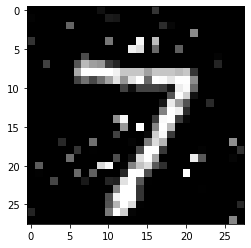

In [16]:
BEST = best + x_test[0]
plt.imshow(BEST.reshape(28,28),cmap='gray')
plt.show()

In [17]:
result=model.predict(best+x_test[0].reshape(1,784))
result[0]

array([5.0582192e-03, 1.1286045e-03, 2.1597841e-01, 2.0335655e-01,
       1.3519490e-04, 1.0958467e-02, 4.8169110e-05, 5.5598086e-01,
       5.1042787e-03, 2.2511834e-03], dtype=float32)

In [18]:
# test
count = 0
for i in range(784):
    if best[i] != 0:
        count+=1
print(count)

104


In [19]:
# test
count = 0
for i in range(784):
    if best[i] > 0.8:
        count+=1
print(count)

9


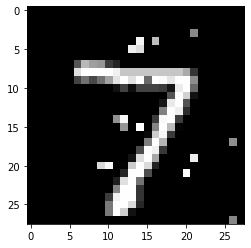

置信度： 0.8821002
[1.5727964e-03 5.0050259e-04 4.2344887e-02 6.5626010e-02 9.7300668e-05
 3.3203713e-03 1.5773265e-05 8.8210022e-01 1.9156543e-03 2.5065257e-03]
扰动程度： 10.441216933212763


In [18]:
#过滤（低强度）
import copy
x_f = copy.deepcopy(best)
for i in range(784):
    if abs(x_f[i]) < 0.5:
        x_f[i] = 0
f = x_f+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(f.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_f))

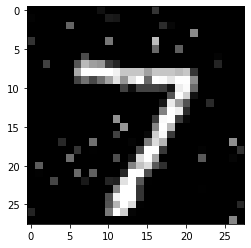

置信度： 0.96857935
[7.3683978e-04 1.5881768e-04 1.2206443e-02 1.5220992e-02 5.0140039e-05
 1.2664554e-03 4.7775175e-06 9.6857935e-01 4.5739426e-04 1.3188313e-03]
扰动程度： 5.589370432973648


In [12]:
#过滤（高强度）
import copy
x_F = copy.deepcopy(best)
for i in range(784):
    if abs(x_F[i]) > 0.8:
        x_F[i] = 0
F = x_F+x_test[0]
plt.imshow(F.reshape(28,28),cmap='gray')
plt.show()
result=model.predict(F.reshape(1,784))
print("置信度：", result[0][7])
print(result[0])
print("扰动程度：",Dis(x_F))

迭代: 1
置信度： 0.88068414


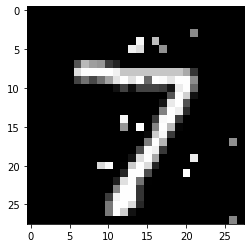

迭代: 2
置信度： 0.87507445


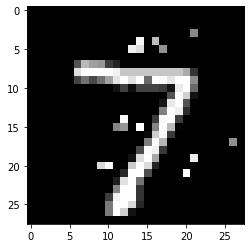

迭代: 3
置信度： 0.87018013


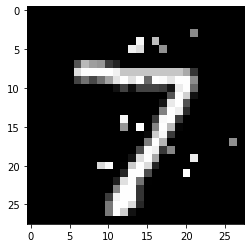

迭代: 4
置信度： 0.8484891


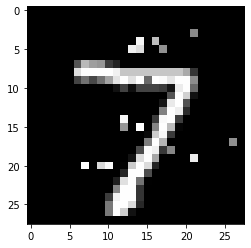

迭代: 5
置信度： 0.84559983


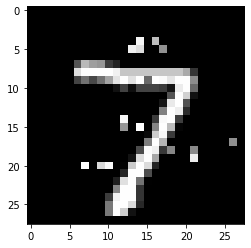

迭代: 6
置信度： 0.8452302


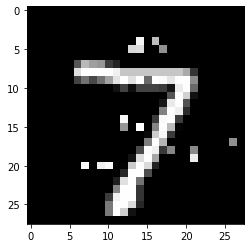

迭代: 7
置信度： 0.84332895


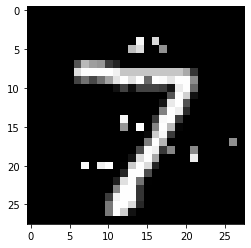

迭代: 8
置信度： 0.8065154


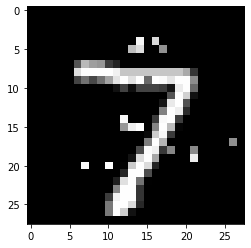

迭代: 9
置信度： 0.75652325


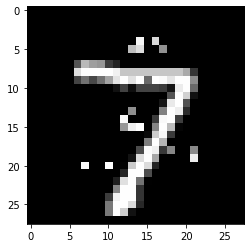

迭代: 10
置信度： 0.7526827


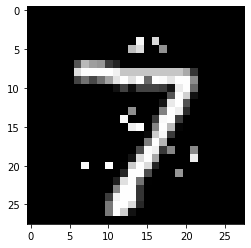

迭代: 11
置信度： 0.7383868


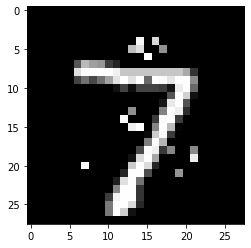

迭代: 12
置信度： 0.73576075


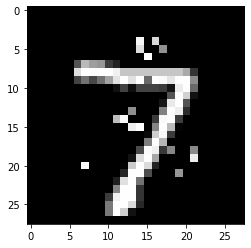

迭代: 13
置信度： 0.72953624


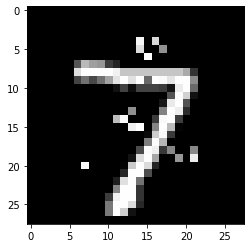

迭代: 14
置信度： 0.7241823


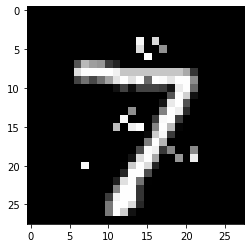

迭代: 15
置信度： 0.71590024


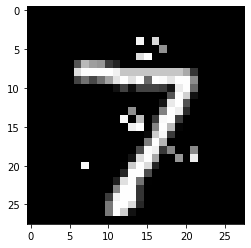

迭代: 16
置信度： 0.6789497


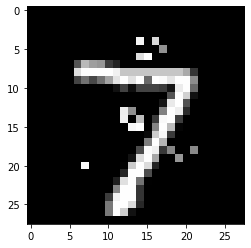

迭代: 17
置信度： 0.6651816


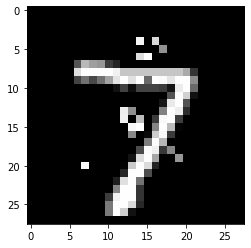

迭代: 18
置信度： 0.6621791


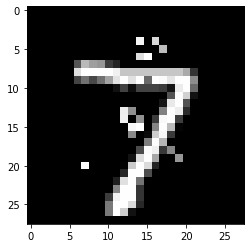

迭代: 19
置信度： 0.6590867


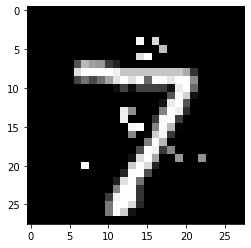

迭代: 20
置信度： 0.6339698


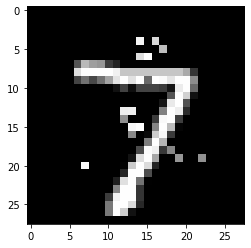

迭代: 21
置信度： 0.63390243


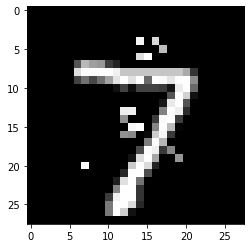

迭代: 22
置信度： 0.62927675


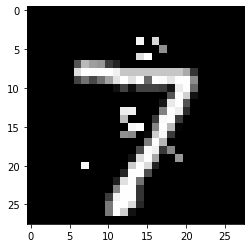

迭代: 23
置信度： 0.62789685


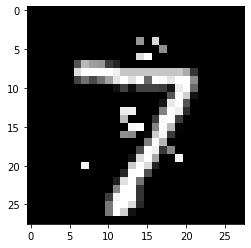

迭代: 24
置信度： 0.62747705


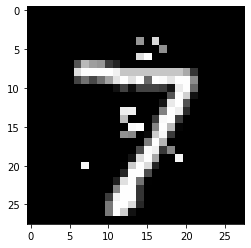

迭代: 25
置信度： 0.6260589


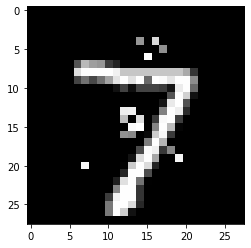

迭代: 26
置信度： 0.6217052


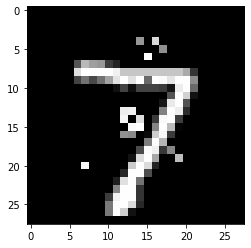

迭代: 27
置信度： 0.61067724


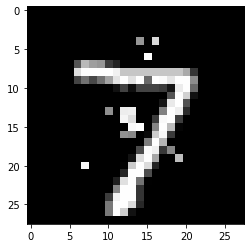

迭代: 28
置信度： 0.6039406


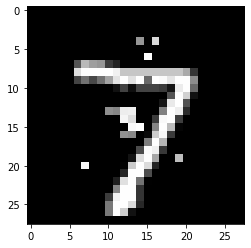

迭代: 29
置信度： 0.60229594


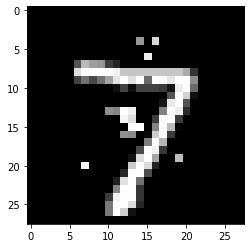

迭代: 30
置信度： 0.5991285


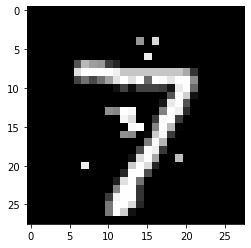

迭代: 31
置信度： 0.59499437


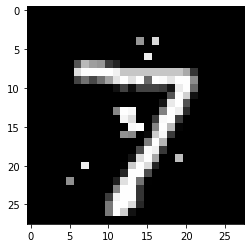

迭代: 32
置信度： 0.59290457


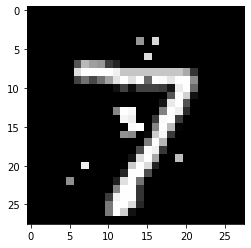

迭代: 33
置信度： 0.5803562


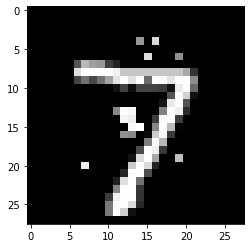

迭代: 34
置信度： 0.57074773


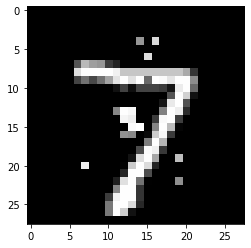

迭代: 35
置信度： 0.55531746


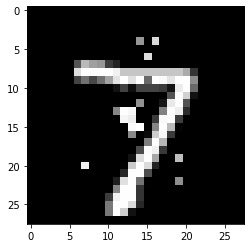

迭代: 36
置信度： 0.5513148


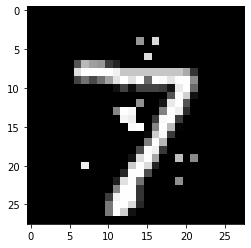

迭代: 37
置信度： 0.5408065


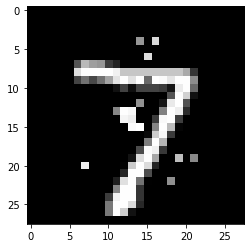

迭代: 38
置信度： 0.534347


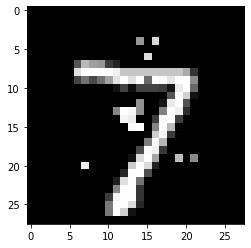

迭代: 39
置信度： 0.53313


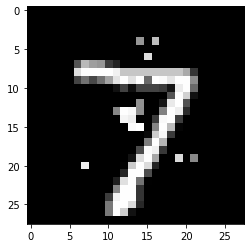

迭代: 40
置信度： 0.5320504


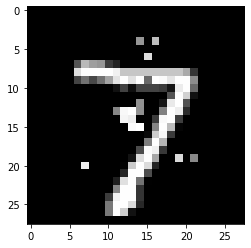

迭代: 41
置信度： 0.5212934


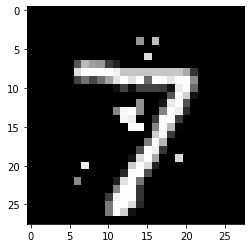

迭代: 42
置信度： 0.51671094


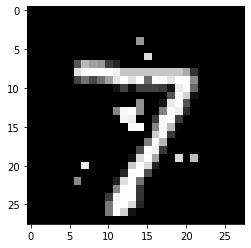

迭代: 43
置信度： 0.51458323


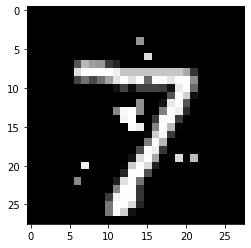

迭代: 44
置信度： 0.51436895


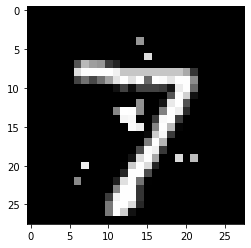

迭代: 45
置信度： 0.5142375


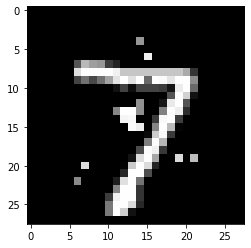

迭代: 46
置信度： 0.5123466


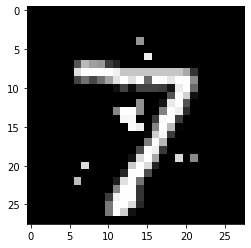

迭代: 47
置信度： 0.51207656


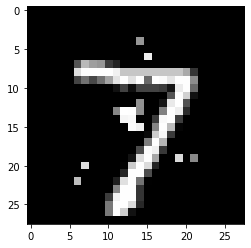

迭代: 48
置信度： 0.5114544


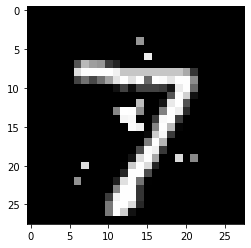

迭代: 49
置信度： 0.51103824


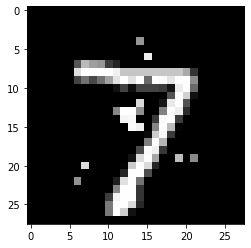

迭代: 50
置信度： 0.5109314


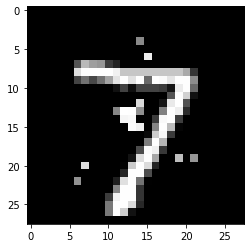

迭代: 51
置信度： 0.5108437


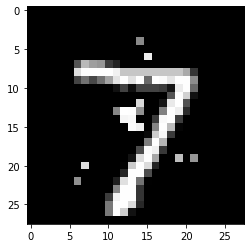

迭代: 52
置信度： 0.5104965


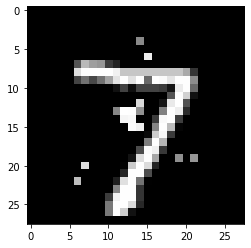

迭代: 53
置信度： 0.51048356


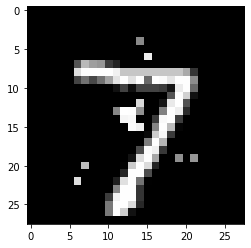

迭代: 54
置信度： 0.5085732


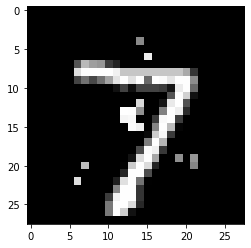

迭代: 55
置信度： 0.5084624


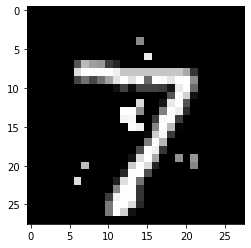

迭代: 56
置信度： 0.5083628


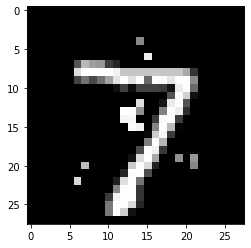

迭代: 57
置信度： 0.5079774


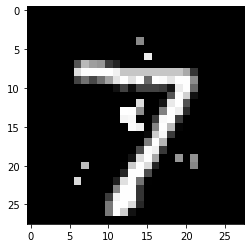

迭代: 58
置信度： 0.5077682


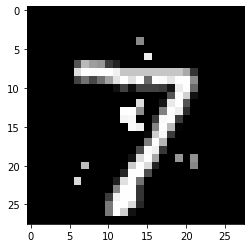

迭代: 59
置信度： 0.50754607


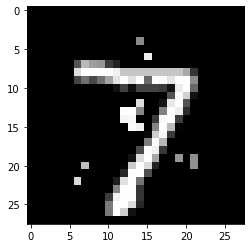

迭代: 60
置信度： 0.50566757


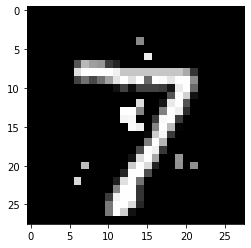

迭代: 61
置信度： 0.50511813


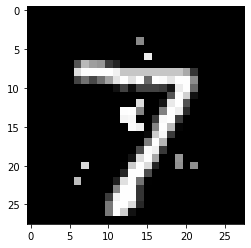

迭代: 62
置信度： 0.5049601


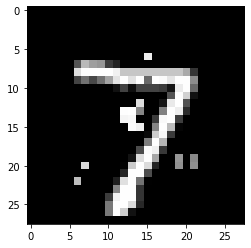

迭代: 63
置信度： 0.5049134


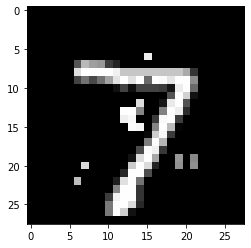

迭代: 64
置信度： 0.5037734


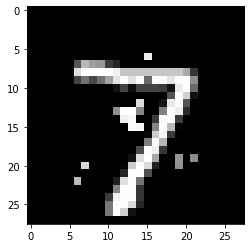

迭代: 65
置信度： 0.5030044


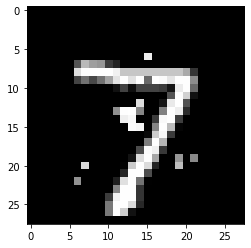

迭代: 66
置信度： 0.5029379


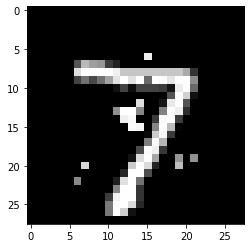

迭代: 67
置信度： 0.5028413


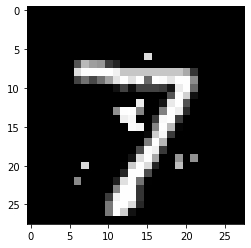

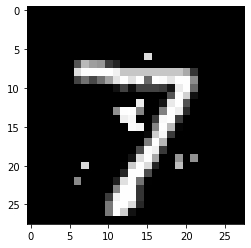

最终置信度： 0.5028413
最终扰动程度： 10.44121693321276
[1.0110943e-03 1.5246284e-03 2.6332267e-02 4.3629068e-01 2.1196678e-04
 8.4788259e-03 1.9245042e-05 5.0284129e-01 1.1336178e-02 1.1953869e-02]


In [21]:
# 改变坐标减小置信度（过滤0.5）
import copy
x_t = copy.deepcopy(x_f)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 2000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代: 1
置信度： 0.9685001


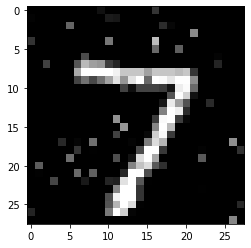

迭代: 2
置信度： 0.96808404


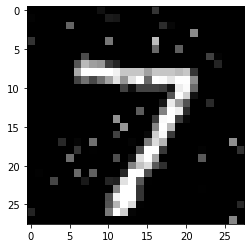

迭代: 3
置信度： 0.9668541


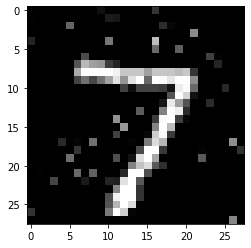

迭代: 4
置信度： 0.96673614


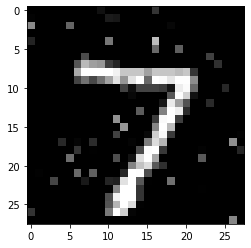

迭代: 5
置信度： 0.9661374


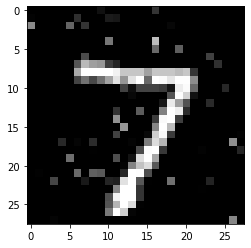

迭代: 6
置信度： 0.9651781


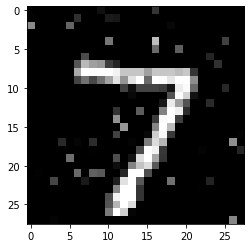

迭代: 7
置信度： 0.962924


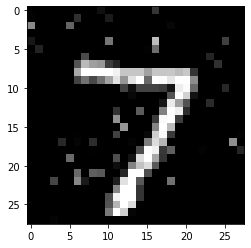

迭代: 8
置信度： 0.9582299


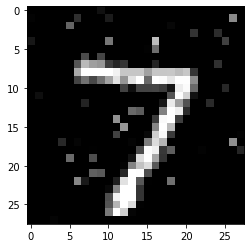

迭代: 9
置信度： 0.95775783


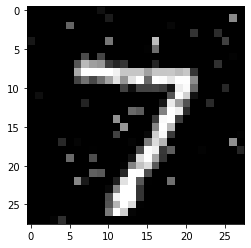

迭代: 10
置信度： 0.95750296


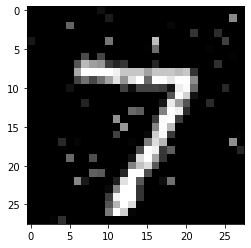

迭代: 11
置信度： 0.9570611


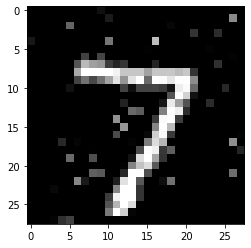

迭代: 12
置信度： 0.9529609


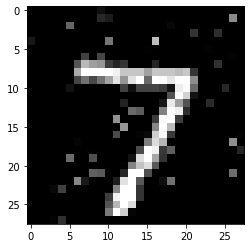

迭代: 13
置信度： 0.95285535


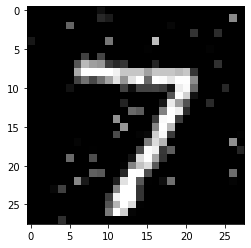

迭代: 14
置信度： 0.9522426


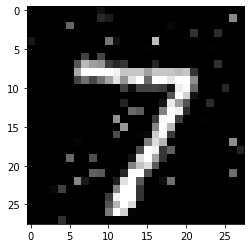

迭代: 15
置信度： 0.9490475


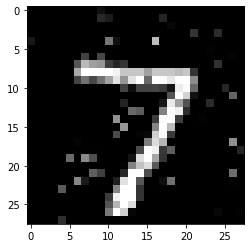

迭代: 16
置信度： 0.9470471


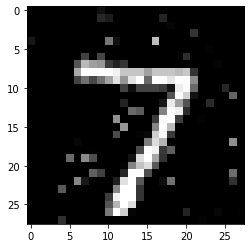

迭代: 17
置信度： 0.94686


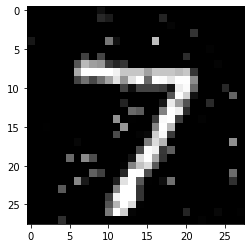

迭代: 18
置信度： 0.9449458


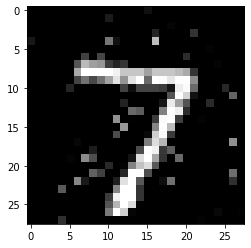

迭代: 19
置信度： 0.9432081


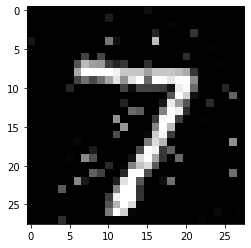

迭代: 20
置信度： 0.9432065


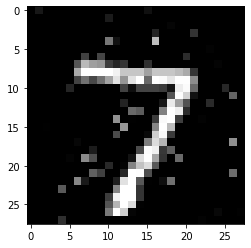

迭代: 21
置信度： 0.9364837


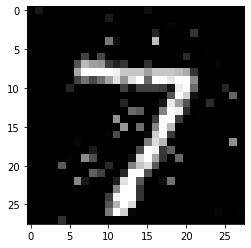

迭代: 22
置信度： 0.93237275


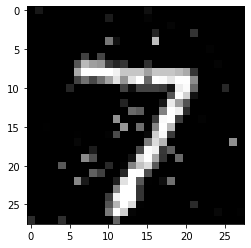

迭代: 23
置信度： 0.9320918


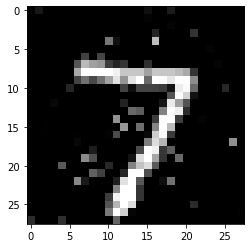

迭代: 24
置信度： 0.9316691


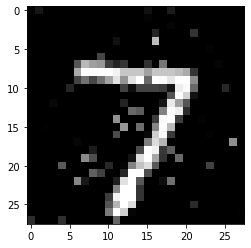

迭代: 25
置信度： 0.9316504


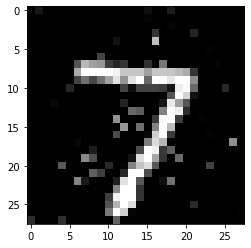

迭代: 26
置信度： 0.9316009


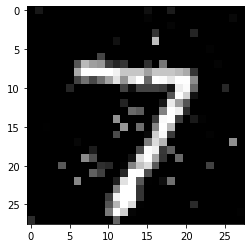

迭代: 27
置信度： 0.92993915


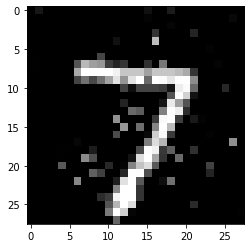

迭代: 28
置信度： 0.92756546


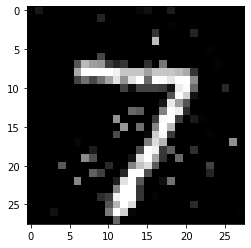

迭代: 29
置信度： 0.92754894


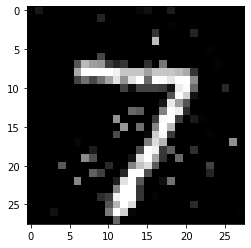

迭代: 30
置信度： 0.92647094


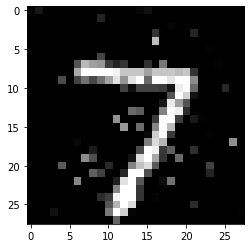

迭代: 31
置信度： 0.9232009


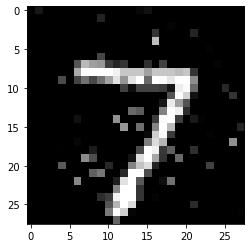

迭代: 32
置信度： 0.9214007


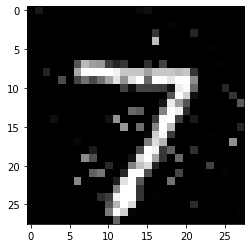

迭代: 33
置信度： 0.9199454


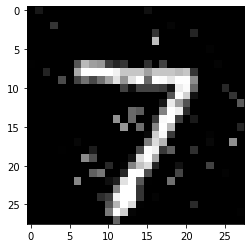

迭代: 34
置信度： 0.9164365


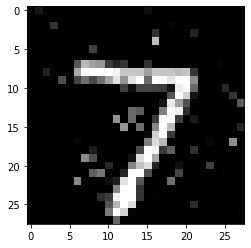

迭代: 35
置信度： 0.9158185


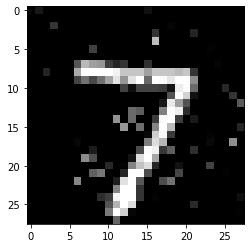

迭代: 36
置信度： 0.90920746


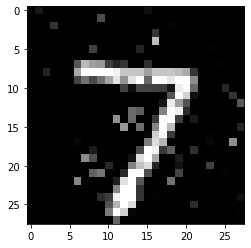

迭代: 37
置信度： 0.9080212


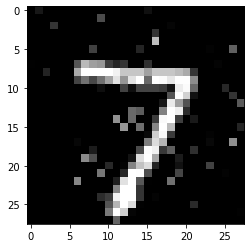

迭代: 38
置信度： 0.9070272


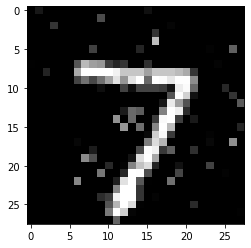

迭代: 39
置信度： 0.90143675


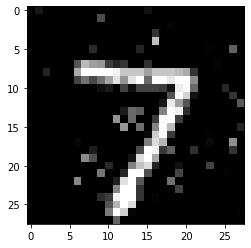

迭代: 40
置信度： 0.9008447


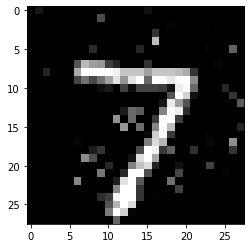

迭代: 41
置信度： 0.89583385


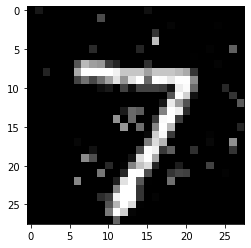

迭代: 42
置信度： 0.89575285


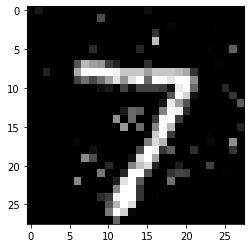

迭代: 43
置信度： 0.895576


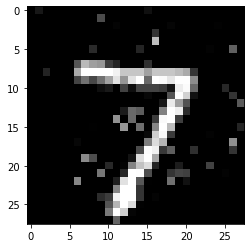

迭代: 44
置信度： 0.89494836


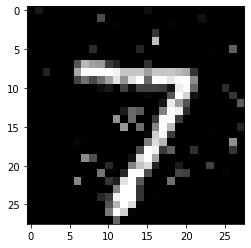

迭代: 45
置信度： 0.89196444


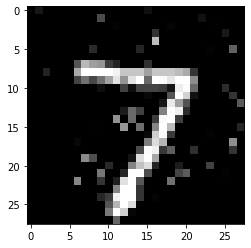

迭代: 46
置信度： 0.89127994


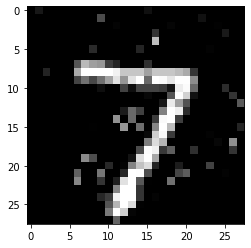

迭代: 47
置信度： 0.89005136


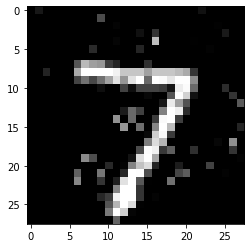

迭代: 48
置信度： 0.8899598


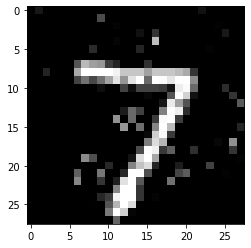

迭代: 49
置信度： 0.88940203


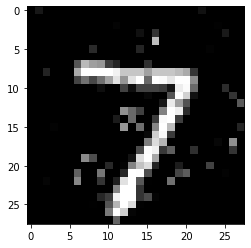

迭代: 50
置信度： 0.88922584


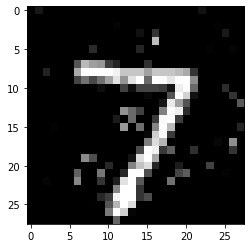

迭代: 51
置信度： 0.8869694


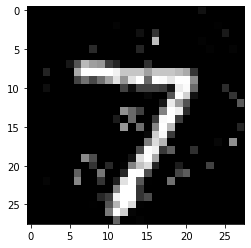

迭代: 52
置信度： 0.88209814


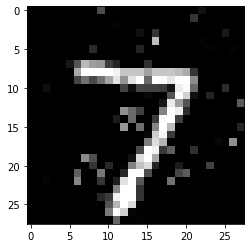

迭代: 53
置信度： 0.88112974


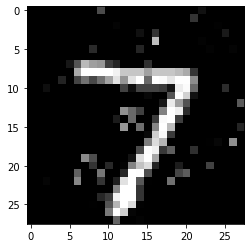

迭代: 54
置信度： 0.8810632


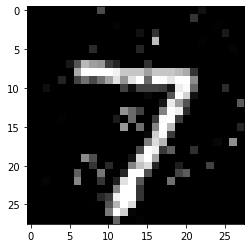

迭代: 55
置信度： 0.87888753


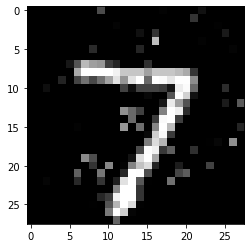

迭代: 56
置信度： 0.87817675


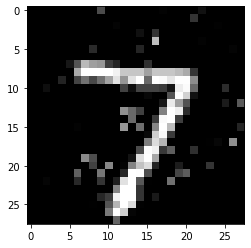

迭代: 57
置信度： 0.87555003


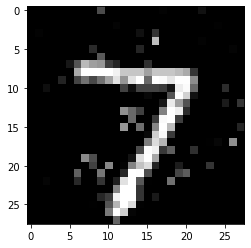

迭代: 58
置信度： 0.87514293


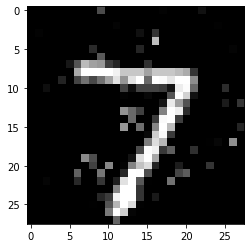

迭代: 59
置信度： 0.8747298


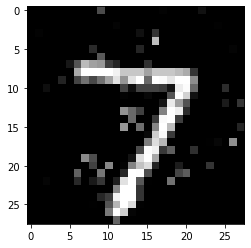

迭代: 60
置信度： 0.87271506


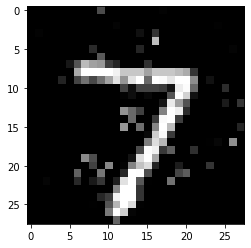

迭代: 61
置信度： 0.868713


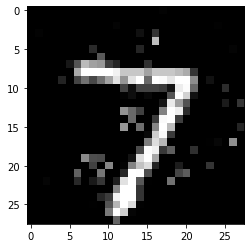

迭代: 62
置信度： 0.8685297


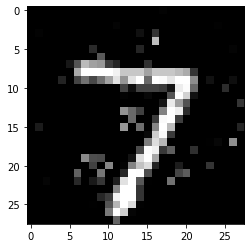

迭代: 63
置信度： 0.8602117


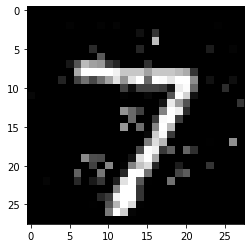

迭代: 64
置信度： 0.85982275


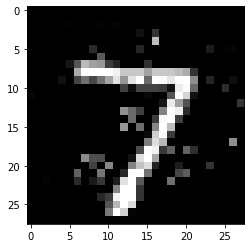

迭代: 65
置信度： 0.8597863


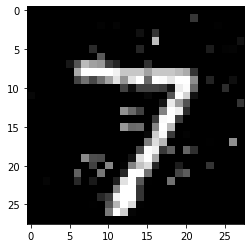

迭代: 66
置信度： 0.8595364


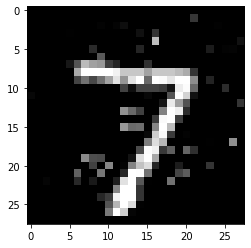

迭代: 67
置信度： 0.8570977


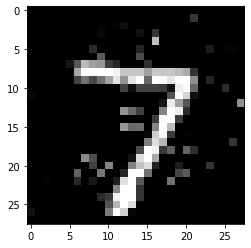

迭代: 68
置信度： 0.8532004


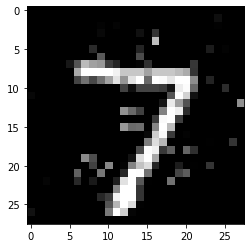

迭代: 69
置信度： 0.8530619


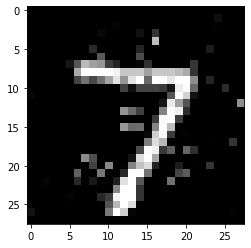

迭代: 70
置信度： 0.85212654


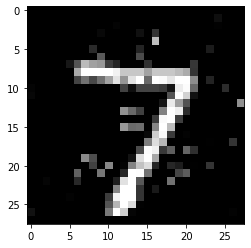

迭代: 71
置信度： 0.85038507


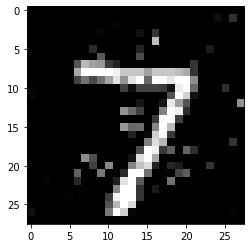

迭代: 72
置信度： 0.8500913


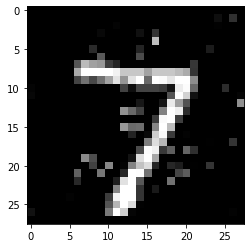

迭代: 73
置信度： 0.846991


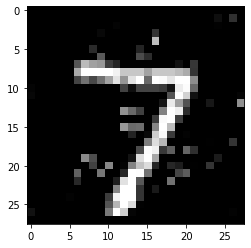

迭代: 74
置信度： 0.84674555


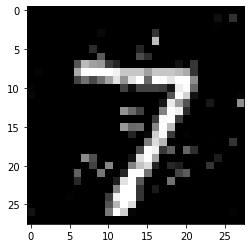

迭代: 75
置信度： 0.84670764


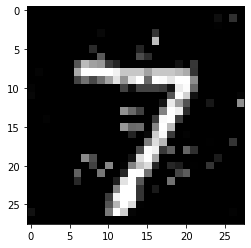

迭代: 76
置信度： 0.84638447


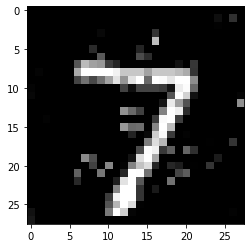

迭代: 77
置信度： 0.8462229


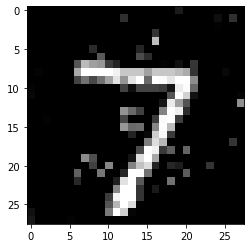

迭代: 78
置信度： 0.8461063


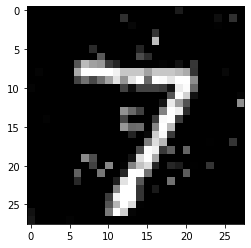

迭代: 79
置信度： 0.84353477


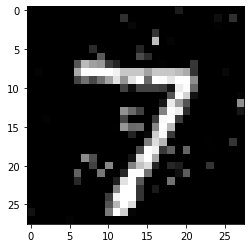

迭代: 80
置信度： 0.8423141


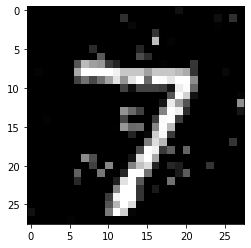

迭代: 81
置信度： 0.841945


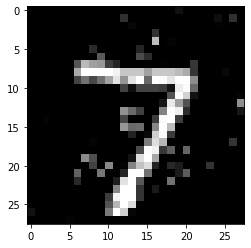

迭代: 82
置信度： 0.8394297


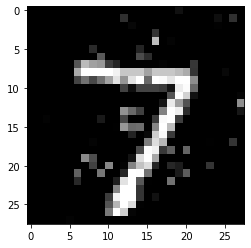

迭代: 83
置信度： 0.83937746


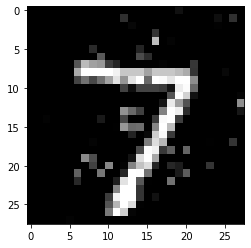

迭代: 84
置信度： 0.8336806


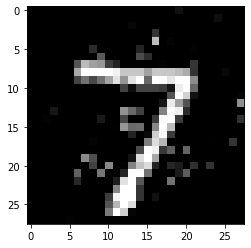

迭代: 85
置信度： 0.8322385


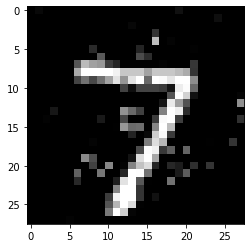

迭代: 86
置信度： 0.83132136


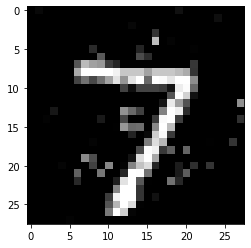

迭代: 87
置信度： 0.8285161


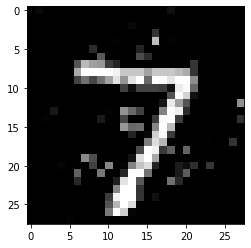

迭代: 88
置信度： 0.8284692


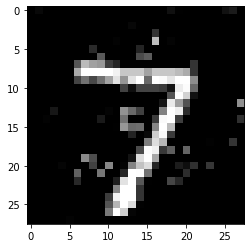

迭代: 89
置信度： 0.82641596


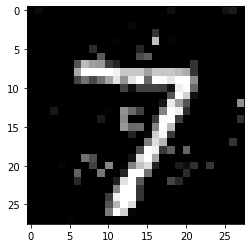

迭代: 90
置信度： 0.823387


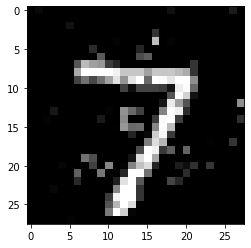

迭代: 91
置信度： 0.8213791


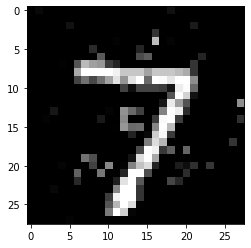

迭代: 92
置信度： 0.81928056


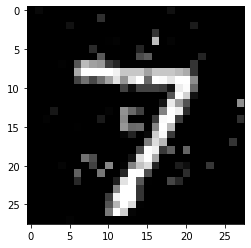

迭代: 93
置信度： 0.81666577


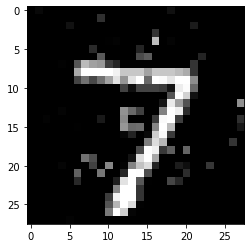

迭代: 94
置信度： 0.8157579


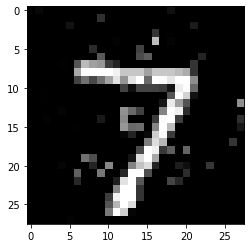

迭代: 95
置信度： 0.81570286


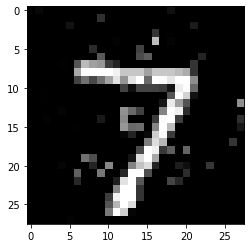

迭代: 96
置信度： 0.8120419


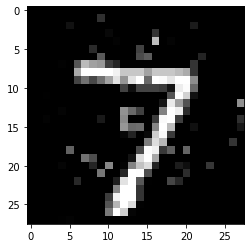

迭代: 97
置信度： 0.8089663


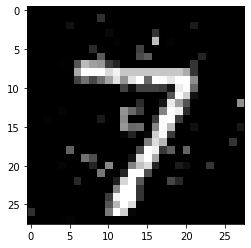

迭代: 98
置信度： 0.80661595


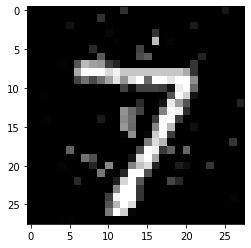

迭代: 99
置信度： 0.7993069


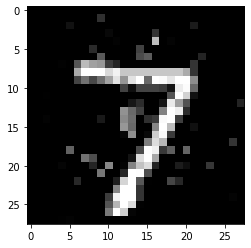

迭代: 100
置信度： 0.79893595


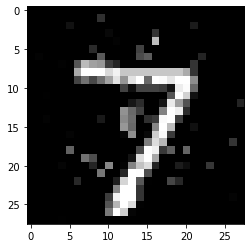

迭代: 101
置信度： 0.7989021


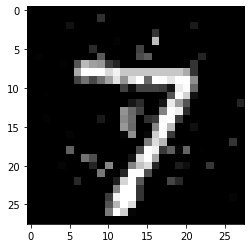

迭代: 102
置信度： 0.7987545


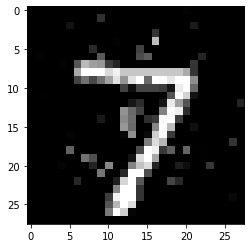

迭代: 103
置信度： 0.7924204


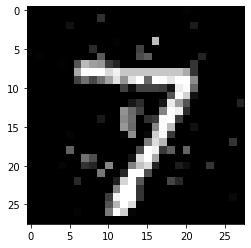

迭代: 104
置信度： 0.79216003


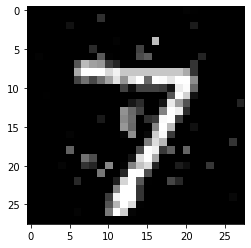

迭代: 105
置信度： 0.79202116


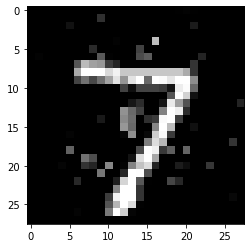

迭代: 106
置信度： 0.7918866


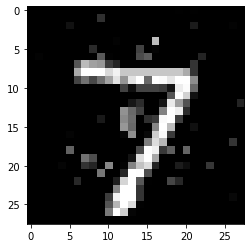

迭代: 107
置信度： 0.7917308


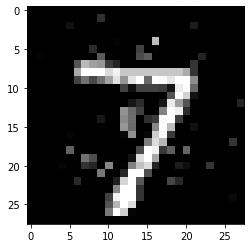

迭代: 108
置信度： 0.7916914


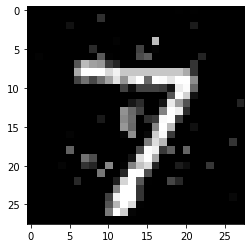

迭代: 109
置信度： 0.7915735


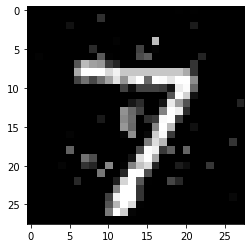

迭代: 110
置信度： 0.79119426


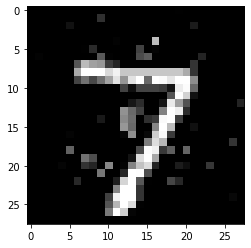

迭代: 111
置信度： 0.7906876


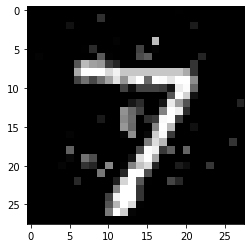

迭代: 112
置信度： 0.78672945


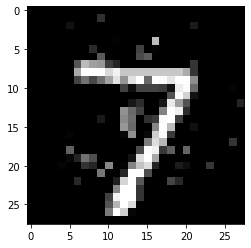

迭代: 113
置信度： 0.7867258


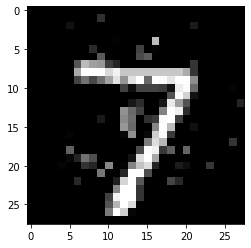

迭代: 114
置信度： 0.7862416


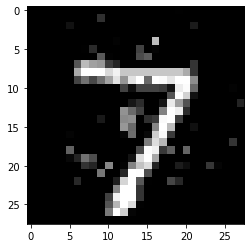

迭代: 115
置信度： 0.78491193


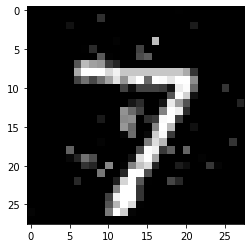

迭代: 116
置信度： 0.781362


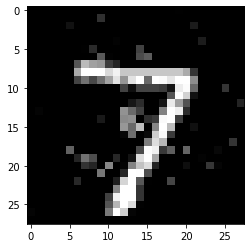

迭代: 117
置信度： 0.77943635


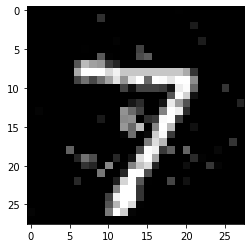

迭代: 118
置信度： 0.7793396


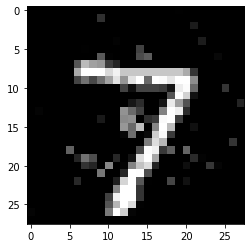

迭代: 119
置信度： 0.7789751


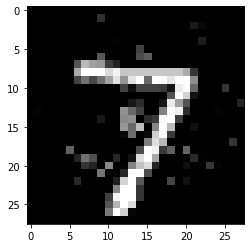

迭代: 120
置信度： 0.7785007


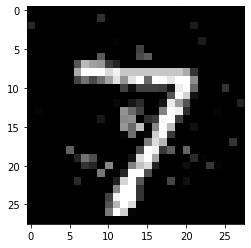

迭代: 121
置信度： 0.77399635


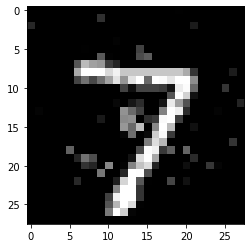

迭代: 122
置信度： 0.7707057


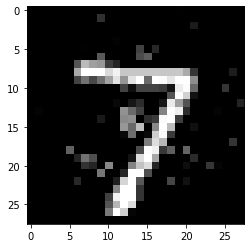

迭代: 123
置信度： 0.7699053


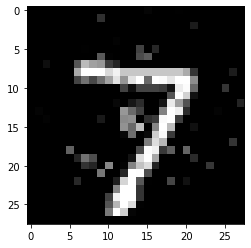

迭代: 124
置信度： 0.76864296


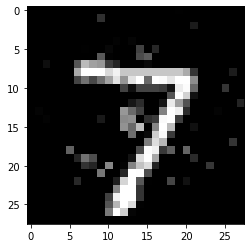

迭代: 125
置信度： 0.7685422


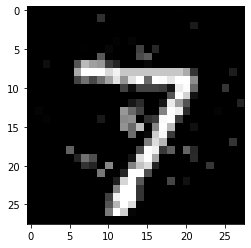

迭代: 126
置信度： 0.76843196


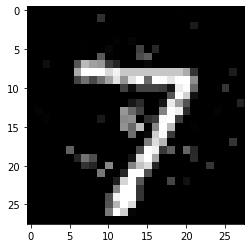

迭代: 127
置信度： 0.7681238


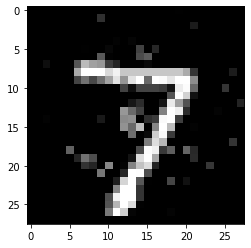

迭代: 128
置信度： 0.76728785


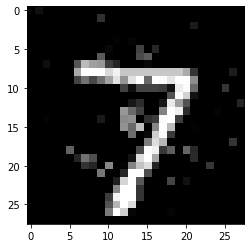

迭代: 129
置信度： 0.7669736


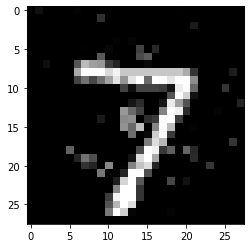

迭代: 130
置信度： 0.76529574


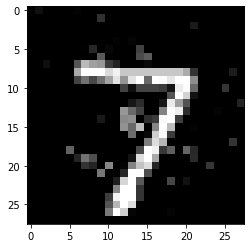

迭代: 131
置信度： 0.76528853


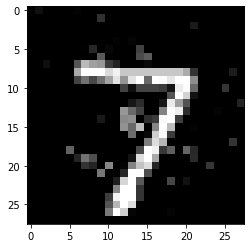

迭代: 132
置信度： 0.7649221


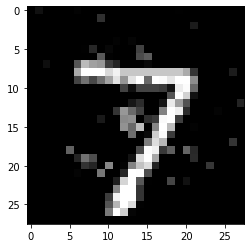

迭代: 133
置信度： 0.76464427


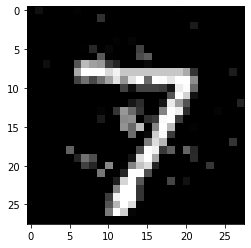

迭代: 134
置信度： 0.764628


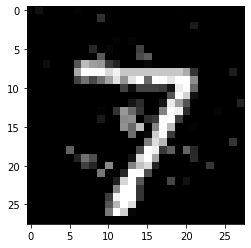

迭代: 135
置信度： 0.76288295


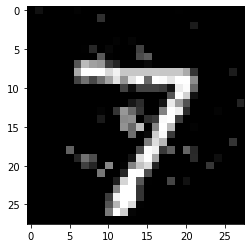

迭代: 136
置信度： 0.7627641


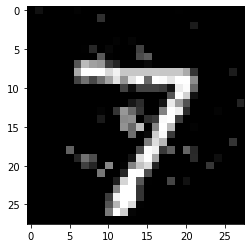

迭代: 137
置信度： 0.76197916


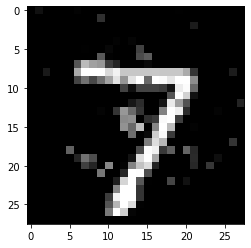

迭代: 138
置信度： 0.76194817


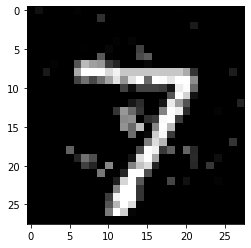

迭代: 139
置信度： 0.7619363


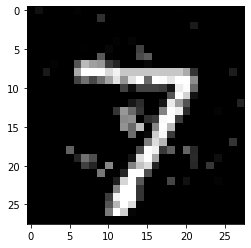

迭代: 140
置信度： 0.7618042


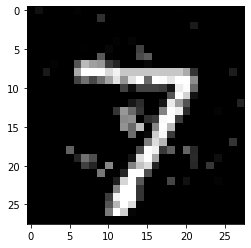

迭代: 141
置信度： 0.76177335


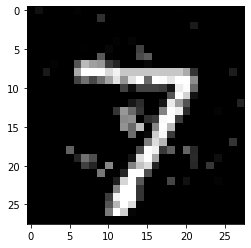

迭代: 142
置信度： 0.76040983


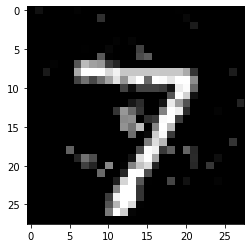

迭代: 143
置信度： 0.7468531


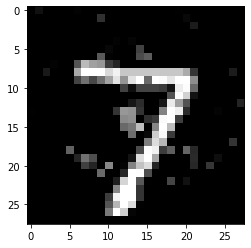

迭代: 144
置信度： 0.7466557


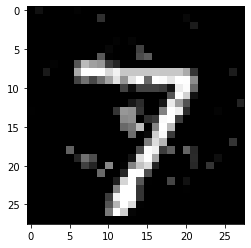

迭代: 145
置信度： 0.7462929


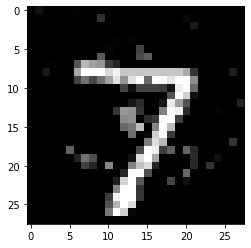

迭代: 146
置信度： 0.74401474


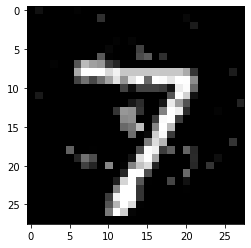

迭代: 147
置信度： 0.7440044


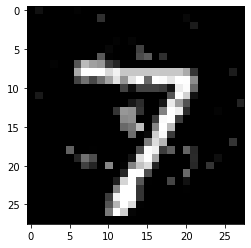

迭代: 148
置信度： 0.7439452


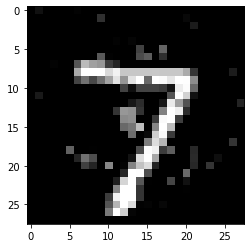

迭代: 149
置信度： 0.7405638


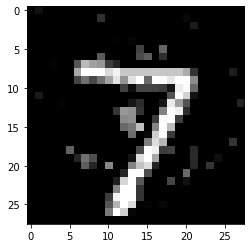

迭代: 150
置信度： 0.7404991


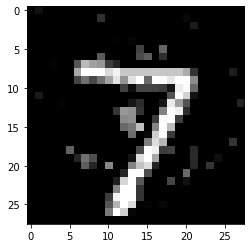

迭代: 151
置信度： 0.73973143


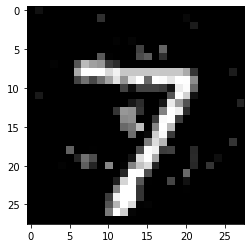

迭代: 152
置信度： 0.73970574


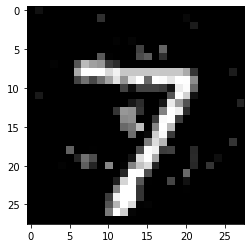

迭代: 153
置信度： 0.7395346


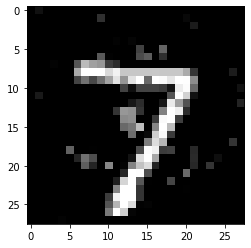

迭代: 154
置信度： 0.73855627


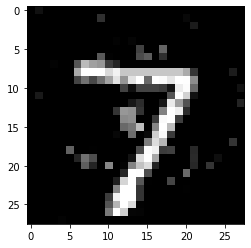

迭代: 155
置信度： 0.7382928


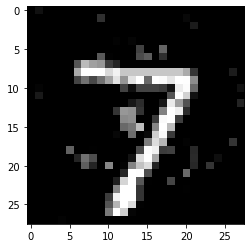

迭代: 156
置信度： 0.73509806


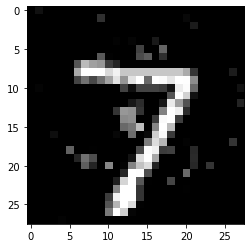

迭代: 157
置信度： 0.7341421


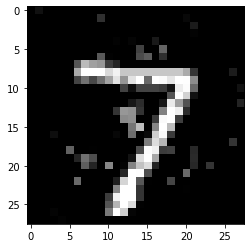

迭代: 158
置信度： 0.7336523


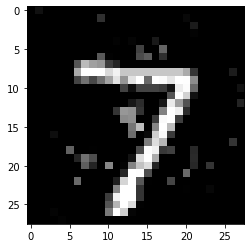

迭代: 159
置信度： 0.7334265


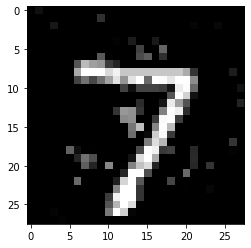

迭代: 160
置信度： 0.7304875


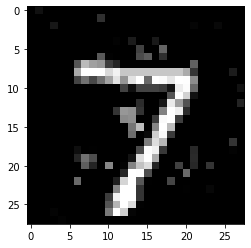

迭代: 161
置信度： 0.7290159


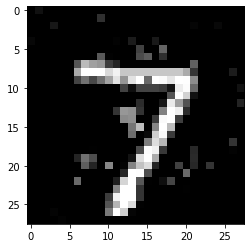

迭代: 162
置信度： 0.7289436


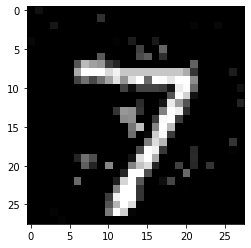

迭代: 163
置信度： 0.7289406


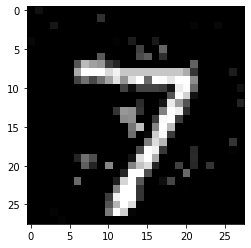

迭代: 164
置信度： 0.7242899


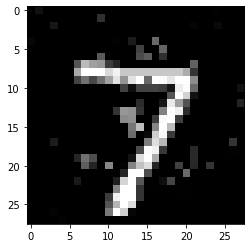

迭代: 165
置信度： 0.72328603


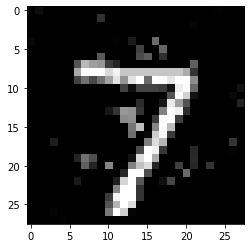

迭代: 166
置信度： 0.72264284


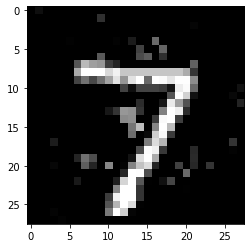

迭代: 167
置信度： 0.71949434


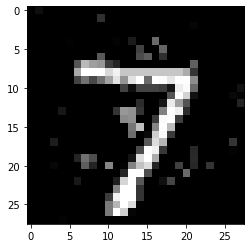

迭代: 168
置信度： 0.71930337


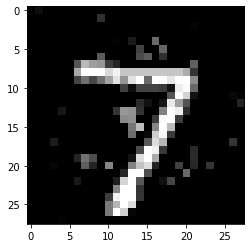

迭代: 169
置信度： 0.71916467


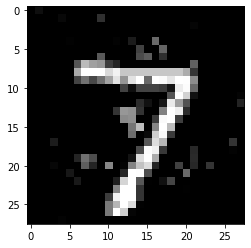

迭代: 170
置信度： 0.7182353


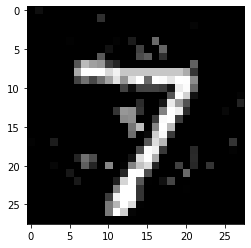

迭代: 171
置信度： 0.7176968


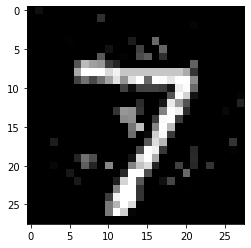

迭代: 172
置信度： 0.7169294


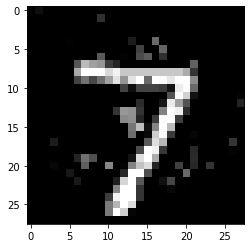

迭代: 173
置信度： 0.71685755


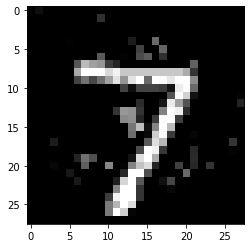

迭代: 174
置信度： 0.7149998


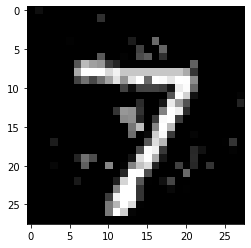

迭代: 175
置信度： 0.71381116


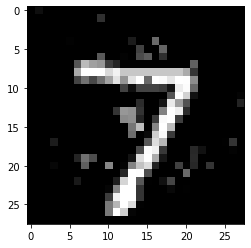

迭代: 176
置信度： 0.7132045


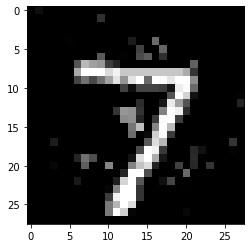

迭代: 177
置信度： 0.7130063


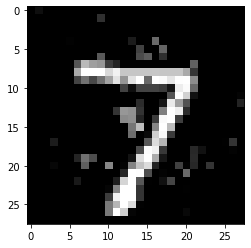

迭代: 178
置信度： 0.7123377


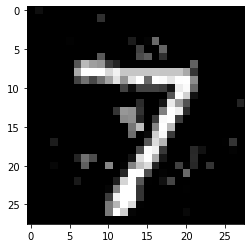

迭代: 179
置信度： 0.7118882


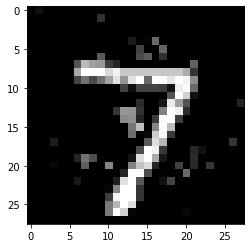

迭代: 180
置信度： 0.7112754


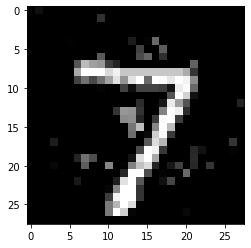

迭代: 181
置信度： 0.70892584


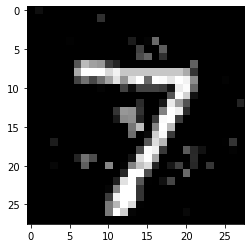

迭代: 182
置信度： 0.7086445


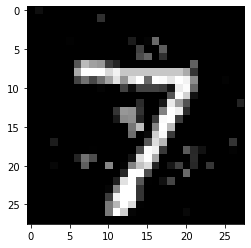

迭代: 183
置信度： 0.70862514


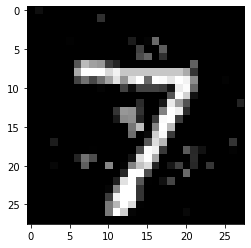

迭代: 184
置信度： 0.7084967


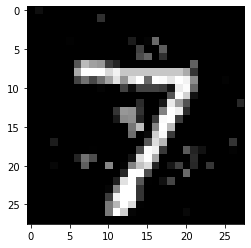

迭代: 185
置信度： 0.70841277


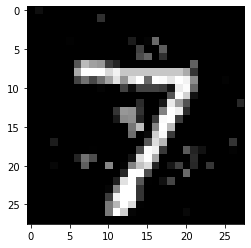

迭代: 186
置信度： 0.70840865


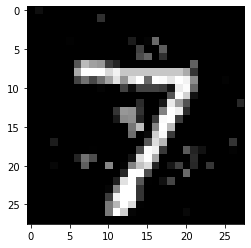

迭代: 187
置信度： 0.70798814


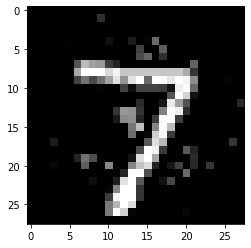

迭代: 188
置信度： 0.7073492


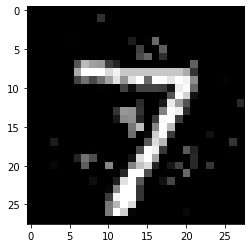

迭代: 189
置信度： 0.70693994


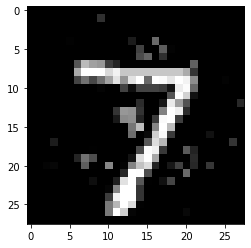

迭代: 190
置信度： 0.70689887


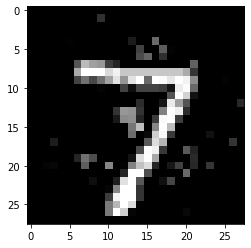

迭代: 191
置信度： 0.70604414


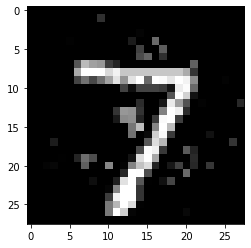

迭代: 192
置信度： 0.70501244


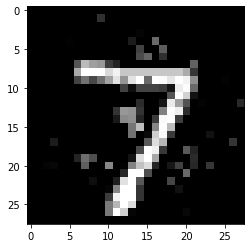

迭代: 193
置信度： 0.70491576


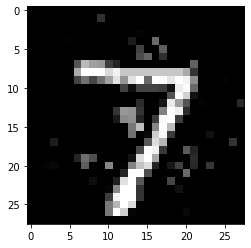

迭代: 194
置信度： 0.70487803


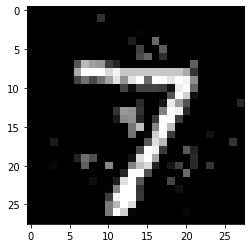

迭代: 195
置信度： 0.70480704


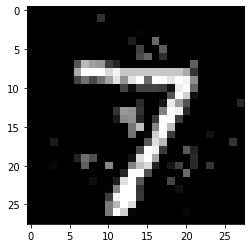

迭代: 196
置信度： 0.70452106


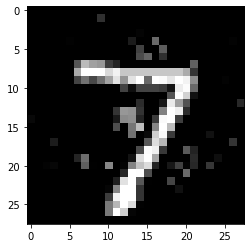

迭代: 197
置信度： 0.7044824


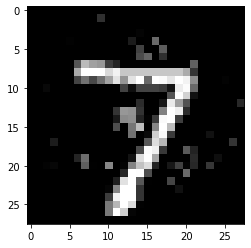

迭代: 198
置信度： 0.7027893


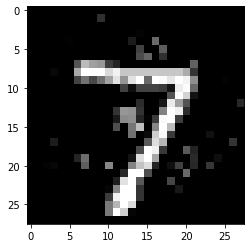

迭代: 199
置信度： 0.70124197


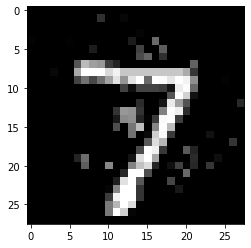

迭代: 200
置信度： 0.7010802


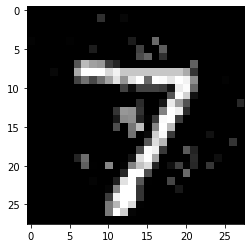

迭代: 201
置信度： 0.7008301


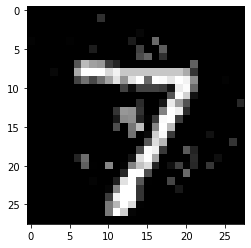

迭代: 202
置信度： 0.69970506


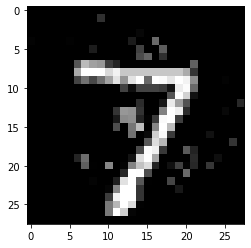

迭代: 203
置信度： 0.6996605


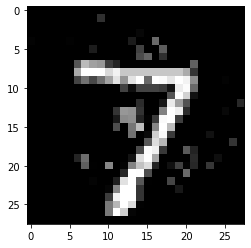

迭代: 204
置信度： 0.69945055


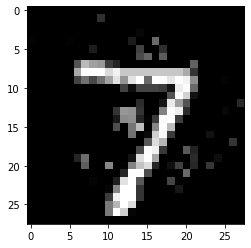

迭代: 205
置信度： 0.6988806


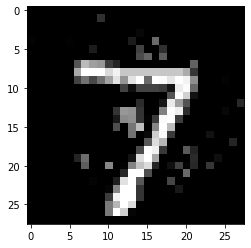

迭代: 206
置信度： 0.69857144


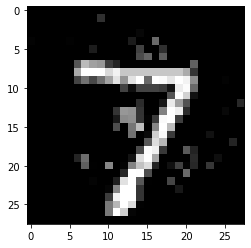

迭代: 207
置信度： 0.69713736


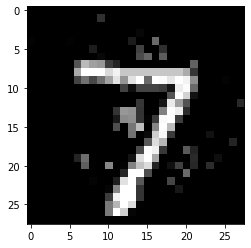

迭代: 208
置信度： 0.6960612


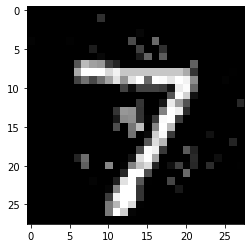

迭代: 209
置信度： 0.69584876


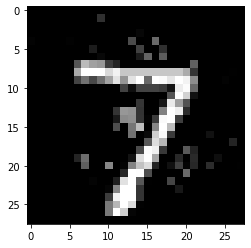

迭代: 210
置信度： 0.6957293


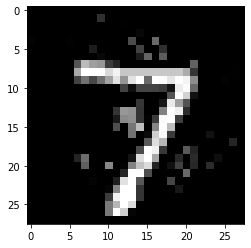

迭代: 211
置信度： 0.69404256


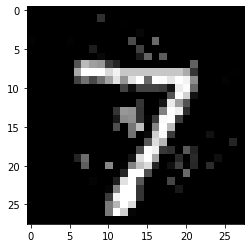

迭代: 212
置信度： 0.6940043


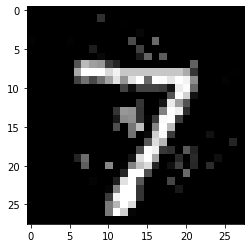

迭代: 213
置信度： 0.69320613


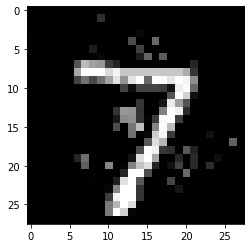

迭代: 214
置信度： 0.6931128


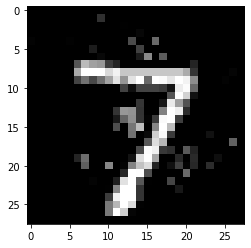

迭代: 215
置信度： 0.69308996


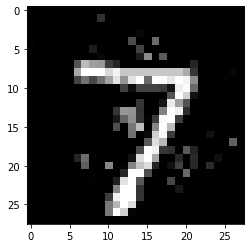

迭代: 216
置信度： 0.6927024


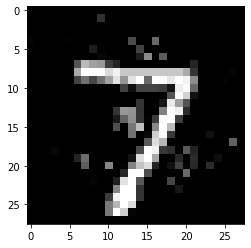

迭代: 217
置信度： 0.6913806


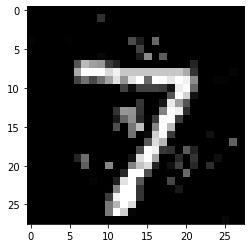

迭代: 218
置信度： 0.6910923


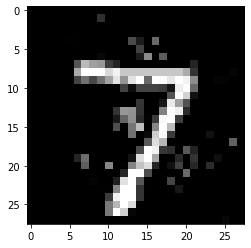

迭代: 219
置信度： 0.6901169


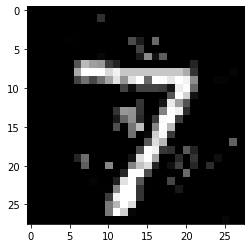

迭代: 220
置信度： 0.6897456


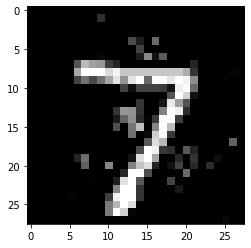

迭代: 221
置信度： 0.68972737


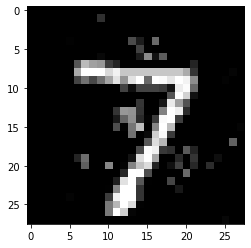

迭代: 222
置信度： 0.689652


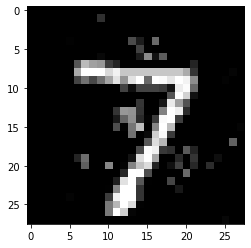

迭代: 223
置信度： 0.68951786


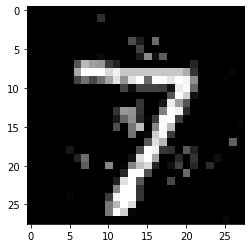

迭代: 224
置信度： 0.6888637


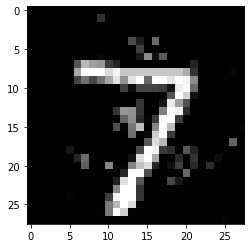

迭代: 225
置信度： 0.6880585


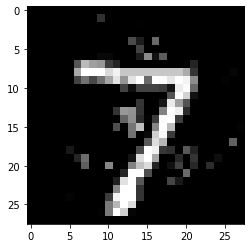

迭代: 226
置信度： 0.68713796


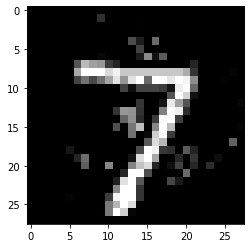

迭代: 227
置信度： 0.68692124


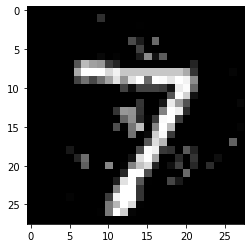

迭代: 228
置信度： 0.686516


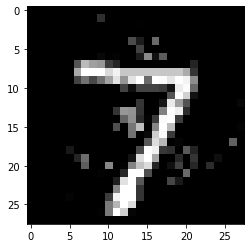

迭代: 229
置信度： 0.68634206


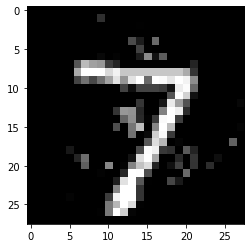

迭代: 230
置信度： 0.68630314


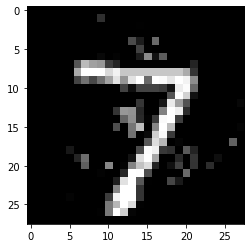

迭代: 231
置信度： 0.68622434


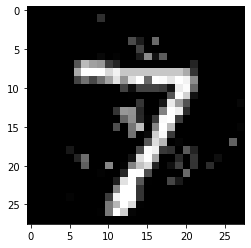

迭代: 232
置信度： 0.6857445


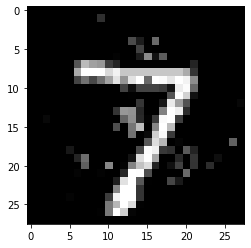

迭代: 233
置信度： 0.68561596


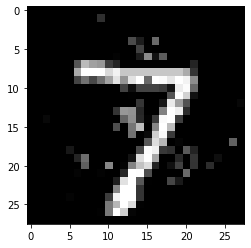

迭代: 234
置信度： 0.6852042


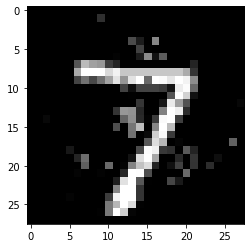

迭代: 235
置信度： 0.68516475


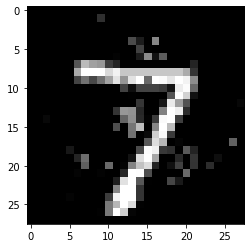

迭代: 236
置信度： 0.6851142


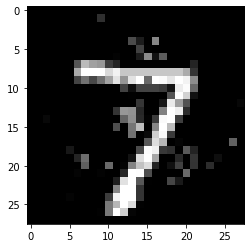

迭代: 237
置信度： 0.6848328


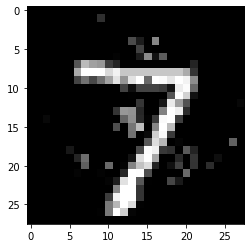

迭代: 238
置信度： 0.6848298


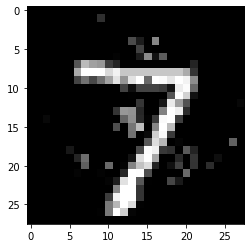

迭代: 239
置信度： 0.68019575


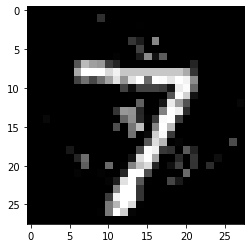

迭代: 240
置信度： 0.67831504


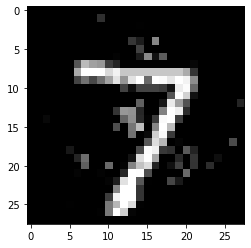

迭代: 241
置信度： 0.6782269


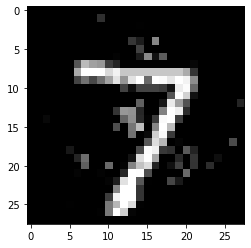

迭代: 242
置信度： 0.677887


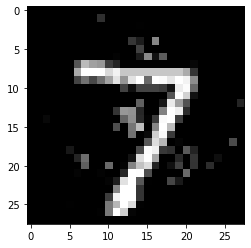

迭代: 243
置信度： 0.6777077


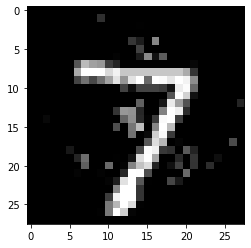

迭代: 244
置信度： 0.6776555


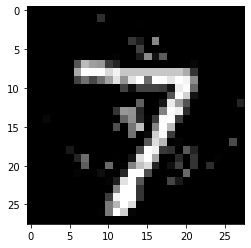

迭代: 245
置信度： 0.67721266


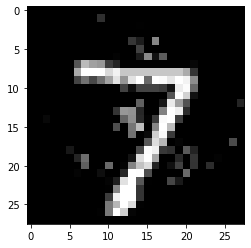

迭代: 246
置信度： 0.6771717


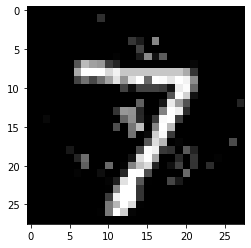

迭代: 247
置信度： 0.67651105


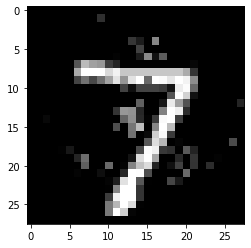

迭代: 248
置信度： 0.6761625


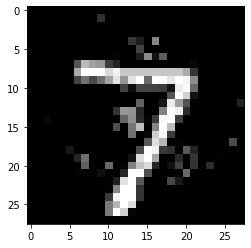

迭代: 249
置信度： 0.67511237


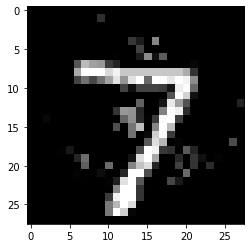

迭代: 250
置信度： 0.6732862


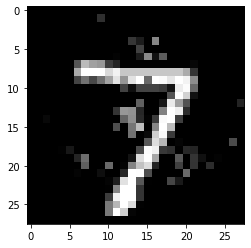

迭代: 251
置信度： 0.6732773


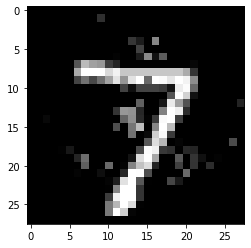

迭代: 252
置信度： 0.67312396


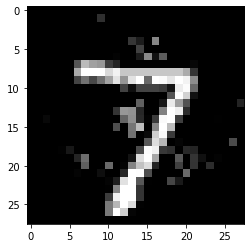

迭代: 253
置信度： 0.6730681


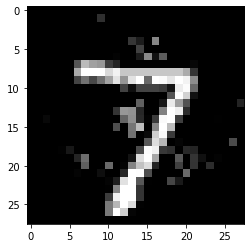

迭代: 254
置信度： 0.6722737


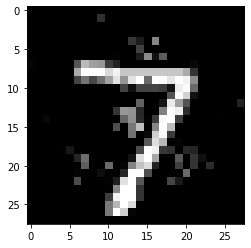

迭代: 255
置信度： 0.6722589


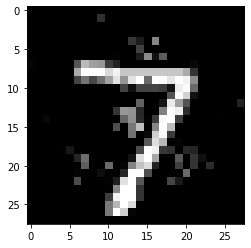

迭代: 256
置信度： 0.67225266


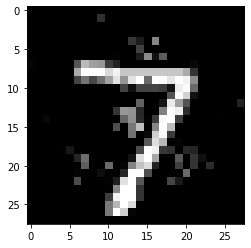

迭代: 257
置信度： 0.6722338


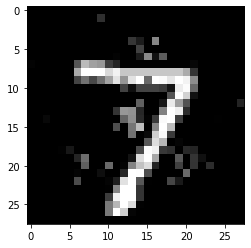

迭代: 258
置信度： 0.6721433


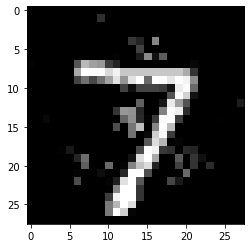

迭代: 259
置信度： 0.6720773


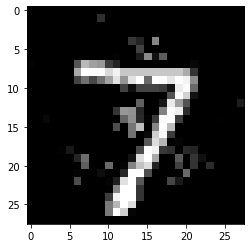

迭代: 260
置信度： 0.67201453


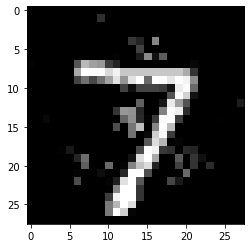

迭代: 261
置信度： 0.6700251


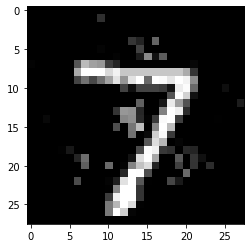

迭代: 262
置信度： 0.6695616


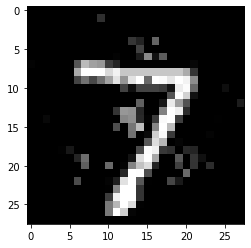

迭代: 263
置信度： 0.6695581


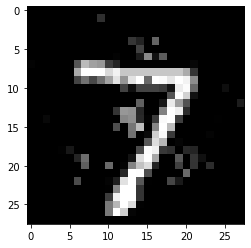

迭代: 264
置信度： 0.6695505


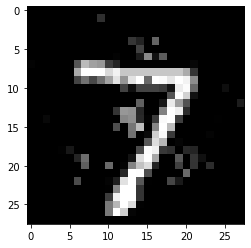

迭代: 265
置信度： 0.6693722


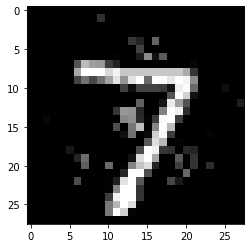

迭代: 266
置信度： 0.6693536


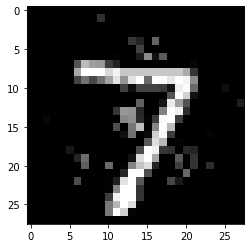

迭代: 267
置信度： 0.6693445


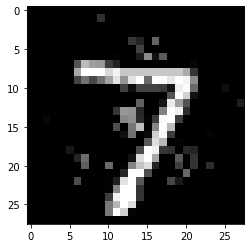

迭代: 268
置信度： 0.66926205


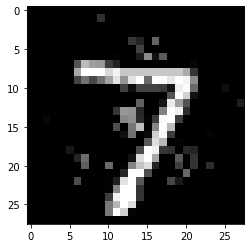

迭代: 269
置信度： 0.6692218


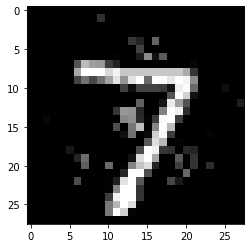

迭代: 270
置信度： 0.66889745


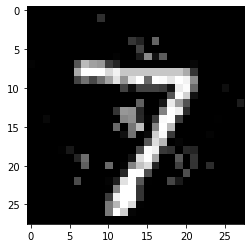

迭代: 271
置信度： 0.66880864


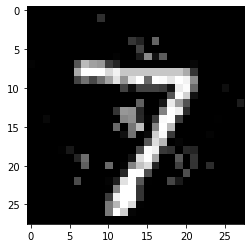

迭代: 272
置信度： 0.6686547


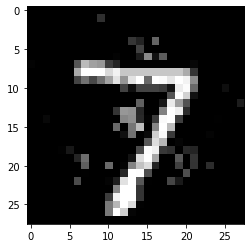

迭代: 273
置信度： 0.66850275


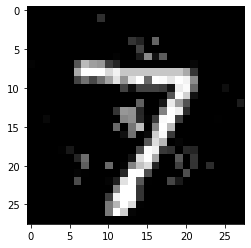

迭代: 274
置信度： 0.6608989


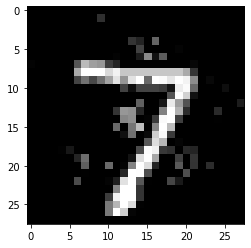

迭代: 275
置信度： 0.6563876


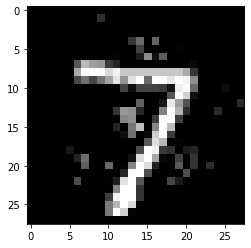

迭代: 276
置信度： 0.65514237


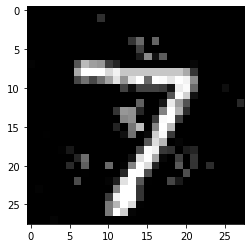

迭代: 277
置信度： 0.655122


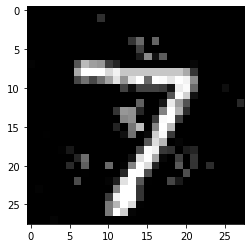

迭代: 278
置信度： 0.6543252


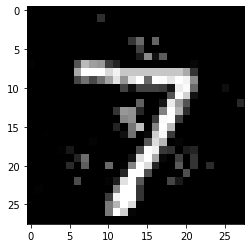

迭代: 279
置信度： 0.65430737


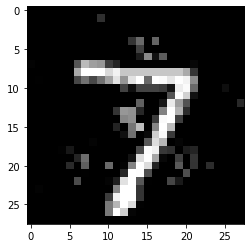

迭代: 280
置信度： 0.65429956


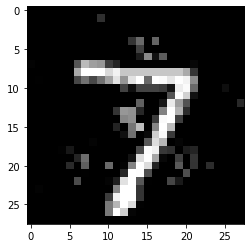

迭代: 281
置信度： 0.6539605


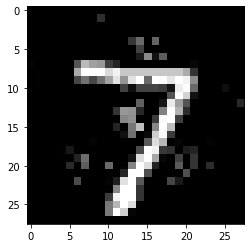

迭代: 282
置信度： 0.6532329


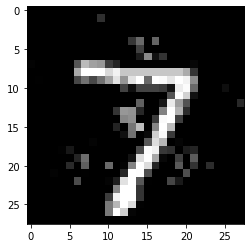

迭代: 283
置信度： 0.6531938


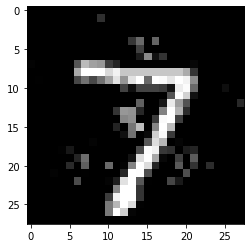

迭代: 284
置信度： 0.6531255


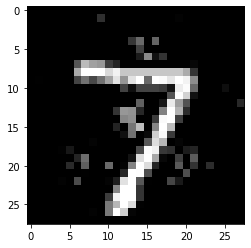

迭代: 285
置信度： 0.6520976


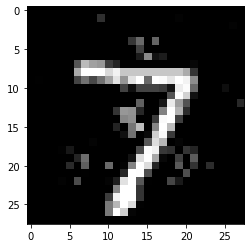

迭代: 286
置信度： 0.6513161


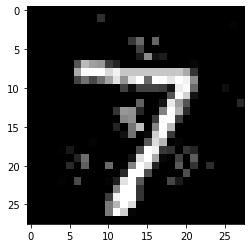

迭代: 287
置信度： 0.65128684


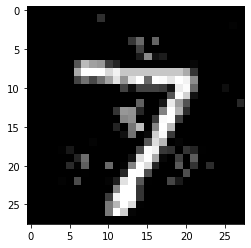

迭代: 288
置信度： 0.6512334


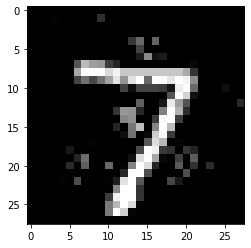

迭代: 289
置信度： 0.650577


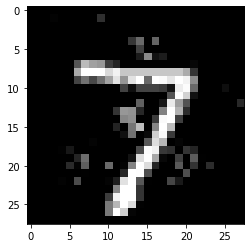

迭代: 290
置信度： 0.6505722


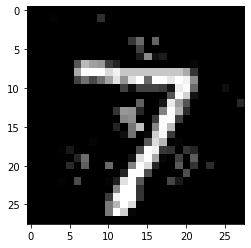

迭代: 291
置信度： 0.6504589


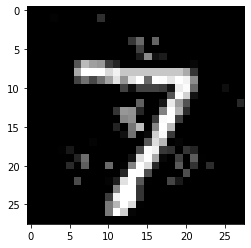

迭代: 292
置信度： 0.6504408


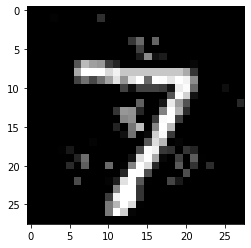

迭代: 293
置信度： 0.6504382


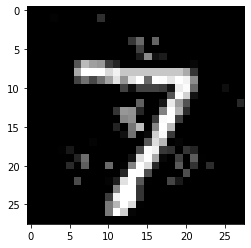

迭代: 294
置信度： 0.6503208


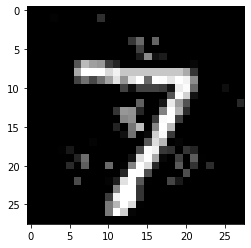

迭代: 295
置信度： 0.65029544


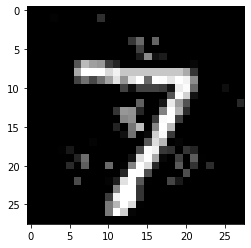

迭代: 296
置信度： 0.65029454


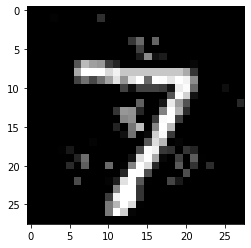

迭代: 297
置信度： 0.6499646


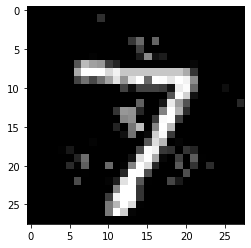

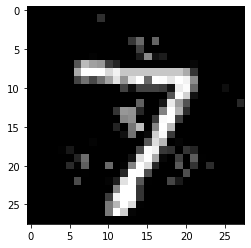

最终置信度： 0.6499646
最终扰动程度： 5.589370432973646
[1.4748638e-03 8.8678574e-04 5.4118227e-02 2.7453902e-01 1.6152140e-04
 6.9625531e-03 1.5526008e-05 6.4996457e-01 6.8239174e-03 5.0530662e-03]


In [24]:
# 改变坐标减小置信度（过滤0.8）
import copy
x_t = copy.deepcopy(x_F)
count = 0
for t in range(300):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 2000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])

迭代失败


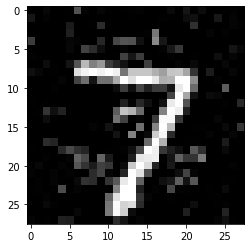

最终置信度： 0.39767227
最终扰动程度： 7.0038201815486
[3.7777259e-03 1.0443135e-03 1.1682559e-01 4.5660120e-01 1.5665211e-04
 1.2439688e-02 3.2627453e-05 3.9767227e-01 7.4698036e-03 3.9801179e-03]


In [11]:
# 改变坐标减小置信度
import copy
x_t = copy.deepcopy(BEST_X)
count = 0
for t in range(80):
    x_f1 = copy.deepcopy(x_t)
    con = 0
    while con < 1000:
        for i in range(784):
            if x_f1[i] > 0:
                x= random.randint(0,10000)/10000
                if x <= 0.1:
                    x_z = x_f1[i]
                    y = random.randint(0,783)
                    f_y = x_f1[y]+x_test[0][i]
                    f_i = x_f1[i]+x_test[0][y]
                    if  (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                        while (f_y >= 1.00000000e+00 or f_y < 0.00000000e+00) or (f_i >= 1.00000000e+00 or f_i < 0.00000000e+00):
                            y = random.randint(0,783)
                            f_y = x_f1[y]+x_test[0][i]
                            f_i = x_f1[i]+x_test[0][y]
                    x_f1[i] = x_f1[y]
                    x_f1[y] = x_z
        #print(Func(x_f1))
        con += 1
        if Func(x_f1) < Func(x_t):
            x_t = x_f1
            count += 1
            print("迭代:",count)
            print("置信度：",Func(x_t))
            f1 = x_t+x_test[0]
            plt.imshow(f1.reshape(28,28),cmap='gray')
            plt.show()
            break
        x_f1 = copy.deepcopy(x_t)
    if con == 1000:
        print("迭代失败")
        break
f = x_t+x_test[0]
plt.imshow(f.reshape(28,28),cmap='gray')
plt.show()
res=model.predict(f.reshape(1,784))
print("最终置信度：", res[0][7])
print("最终扰动程度：", Dis(x_t))
print(res[0])